In [54]:
import gym
import torch
import gym_nav
import numpy as np

import sys
sys.path.append('../')
from evaluation import *
from model_evaluation import *
from trajectories import *
from shortcut_analysis import *
from explore_analysis import *
from plotting_utils import *
from read_experiments import *

from representation_analysis import *
from population_representations import *
from individual_node_representations import *

from tqdm import tqdm
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

from pathlib import Path
import shutil

set_rc()

# chk_sched to plot with
chks1 = np.arange(0, 150, 10) #0-1e6
chks2 = np.arange(160, 300, 20) #1e6-2e6
chks3 = np.arange(300, 600, 40) #2e6-4e6
chks4 = np.arange(620, 930, 60) #4e6-6e6
chk_sched = np.concatenate([chks1, chks2, chks3, chks4])

# Note actual folders are suffixed with _policy and _copied
wsns_data = {
    'control': {
        'tasks':  [0.0, 0.1, 0.2, 0.3, 0.5, 0.8, 1.0],
        'labels': [f'p={p}' for p in [0.0, 0.1, 0.2, 0.3, 0.5, 0.8, 1.0]],
        'folder_prefix': 'wc1.5',
    },
    'aux': { # Auxiliary tasks
        'tasks': ['catfacewall',  'catquad', 'catwall01', 'wall01'],
        'labels': [u'\u00D7 Faced Wall', u'\u00D7 Quadrant Pos.',
          u'\u00D7 Left Right (N/E)', '\u25A0 Angle Dist. (N/E)'],
        'folder_prefix': 'sc_aux',
    },
    'pre': { # Pretraining tasks
        'tasks':  ['3_0.1_0.1', '3_0.4_0.1', '1.7_0.1', '2.7_0.1'],
        'labels': ['Plum Shortcut p=0.1', 'Plum Shortcut p=0.4', 'Plum Grid', 'Plum Maze'],
        'folder_prefix': 'plum2sc',
    },
    'scwplum': {
        'tasks': [0.1],
        'labels': ['p=0.1 with Plum start'],
        'folder_prefix': 'scwplum'
    }
}

save = Path('plots/')

In [55]:
# Individual node representation data

comb_folder = Path('data/shortcut/combined/')
k12 = pickle.load(open(comb_folder/'kmeans_12', 'rb'))
summary = pickle.load(open(comb_folder/'summary', 'rb'))
all_wsnshm_dist = pickle.load(open(comb_folder/'wsnshm_dist', 'rb'))
all_center_dist = pickle.load(open(comb_folder/'controlk_center_dist', 'rb'))
all_local_vars = pickle.load(open(comb_folder/'local_variability', 'rb'))

k = k12['control'][1]
k_pair_targets = pickle.load(open(comb_folder/'kmeans_12_pair_targets', 'rb'))
pairs = get_best_negative_cluster_pairs(k.cluster_centers_)
centers = k.cluster_centers_
x = chk_sched*64*100

probs = [0.1, 0.2, 0.3, 0.5, 0.8]
trials = range(10)

# Environment drawings

Drawings of what different environments and training conditions look like

meta NOT subset; don't know how to subset; dropped


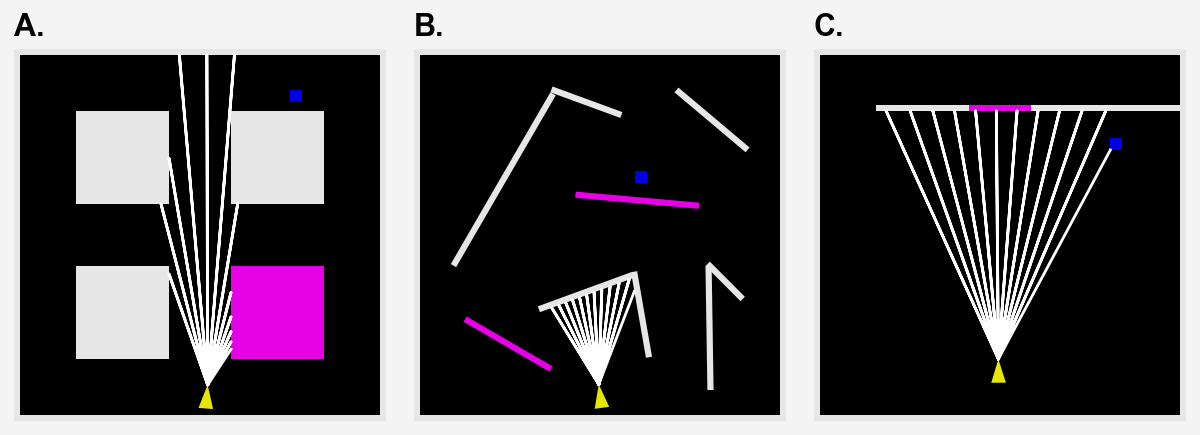

In [58]:
set_trajectory_plot_style()

fig, ax = pplt.subplots(ncols=3, figwidth=6)

tasks = [1.7, 2.7, 3]
p = 0

np.random.seed(0)
for i, task in enumerate(tasks):
    env = gym.make('PlumNav-v0', task_structure=task, 
                   shortcut_probability=p, num_plums=1,
                   wall_thickness=5)
    env.reset()
    env.character.size = 20
    env.render('human', ax=ax[i])
    
    
ax.format(xlim=[0, 300], ylim=[0, 300], abc='A.')
set_rc()

fig.savefig(save/'1_pretraining_envs')

## Main Environment Drawing

meta NOT subset; don't know how to subset; dropped


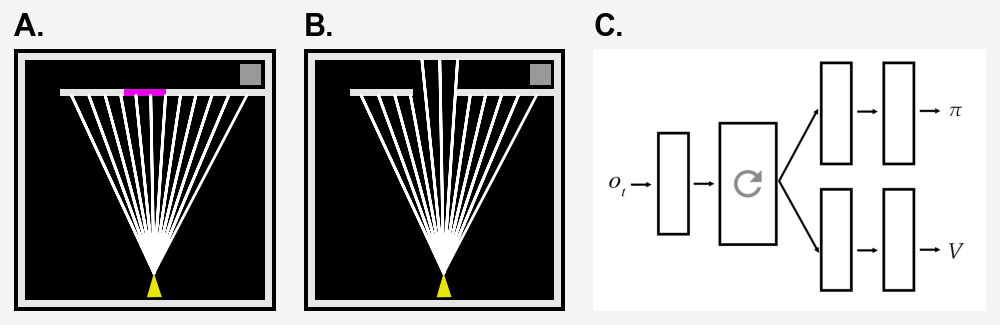

In [113]:
import matplotlib.image as mpimg

set_rc()
pplt.rc.update({
    'axes.spines.bottom': False,
    'axes.spines.top': False,
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.facecolor': 'black',
    'axes.grid': False
})

fig, ax = pplt.subplots(ncols=3, width_ratios=[1, 1, 1.5], figwidth=5, sharey=False)

env = gym.make('ShortcutNav-v0', shortcut_probability=0, 
               wall_colors=1.5, wall_thickness=8)
env.seed(0)
env.reset()
env.character.size = 30
env.render('human', ax=ax[0])

env = gym.make('ShortcutNav-v0', shortcut_probability=1, 
               wall_colors=1.5, wall_thickness=8)
env.seed(0)
env.reset()
env.character.size = 30
env.render('human', ax=ax[1])

ax[2].imshow(mpimg.imread('plots/nn_diagram.png'))
ax[:2].format(xlim=[-5, 305], ylim=[-5, 305])
ax.format(abc='A.')

fig.savefig(save/'1_1_env_and_nn')

# Learning curves and control performance

Used for first results section of learning curves

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


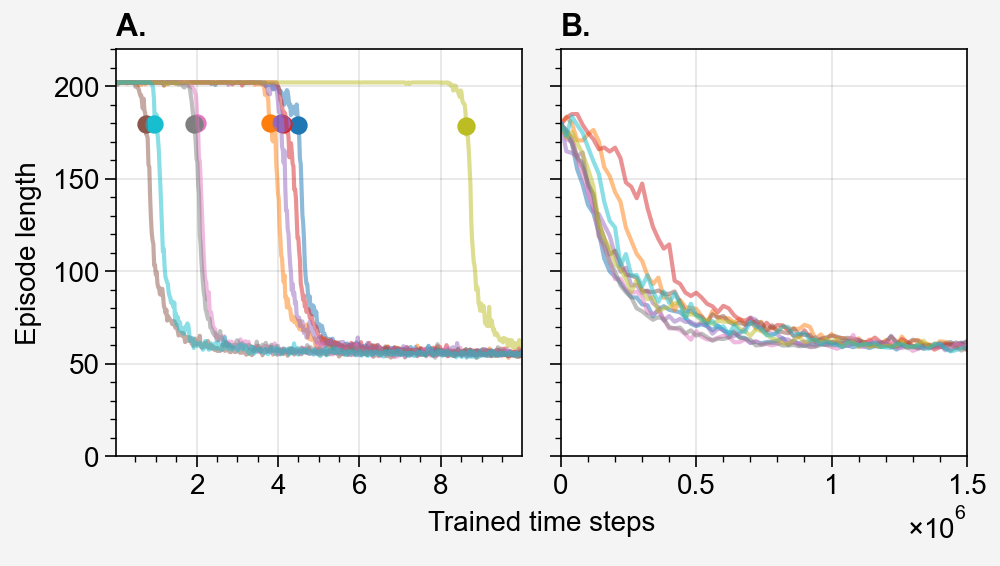

In [13]:
exp_format = 'shortcut_wc1.5p0.1longer_t{t}'
cont_format = 'shortcut_wc1.5p0.1longer_cont_t{t}'

fig, ax = pplt.subplots(ncols=2, figwidth=5)
for i in range(10):
    df = combine_cont_df(exp_format, cont_format, formatter={'t': i},)
    x, y = get_run_df_metric(df)
    first = get_first_shortcut_performance(x, y, ret_chk=False)
    
    
    if not first:
        continue
    ax[0].plot(x[::100]/1000000, y[::100], color=rgb_colors[i], alpha=0.5)
    ax[0].scatter([x[first]/1000000], [y[first]], color=rgb_colors[i])
    
    ax[1].plot(x[first:][::100]-x[first], y[first:][::100], color=rgb_colors[i], alpha=0.5)
    
    
ax.format(xlabel='Trained time steps', ylabel='Episode length',
          # title=['Original Learning Curve', 'Shifted Learning Curve'],
         abc='A.',
         ylim=[0, 220])
ax[0].format(xlocator=[0, 2, 4, 6, 8])
ax[1].format(xlocator=np.array([0, 0.5, 1, 1.5])*1e6,
            xlim=[0, 1.5e6])

fig.savefig(save/'2_p01_shifted_learning_curves')


## p Training performance curves

meta NOT subset; don't know how to subset; dropped


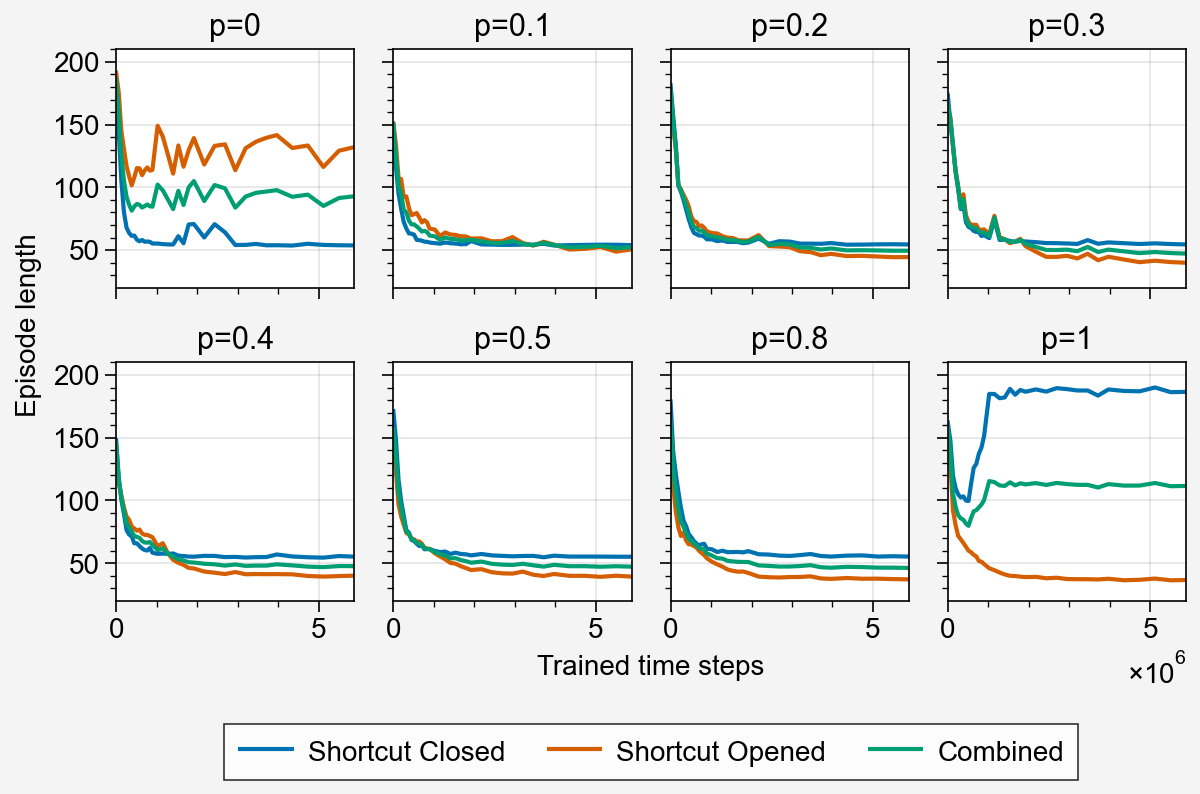

In [61]:
probs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
prob_labels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1]
trials = range(10)
folder = Path('data/shortcut/wc1.5_policy')

summary = pickle.load(open(folder/'summary', 'rb'))

fig, ax = pplt.subplots(nrows=2, ncols=4, figwidth=6)

x = chk_sched * 64 * 100
for i, p in enumerate(probs):
    lines = []
    x_plot = x
    if i in [0, 1, 2, 4, 5, 6]:
        x_plot = x_plot / 1000000
    
    if p == 0.3:
        for key in ['ns_lens', 'ws_lens', 'comb_lens', 'surs']:
            del summary[p][key][2]
    if p == 0.1:
        for key in ['ns_lens', 'ws_lens', 'comb_lens', 'surs']:
            del summary[p][key][8]
    
    lines.append(ax[i].plot(x_plot, np.mean(summary[p]['ns_lens'], axis=0), label='Shortcut Closed'))
    lines.append(ax[i].plot(x_plot, np.mean(summary[p]['ws_lens'], axis=0), label='Shortcut Opened'))
    lines.append(ax[i].plot(x_plot, np.mean(summary[p]['comb_lens'], axis=0), label='Combined'))

fig.legend(lines, loc='b')
ax.format(xlabel='Trained time steps', ylabel='Episode length',
          title=[f'p={p}' for p in prob_labels], ylim=[20, 210])
fig.savefig(save/'2_1_p_performance_curves')

meta NOT subset; don't know how to subset; dropped


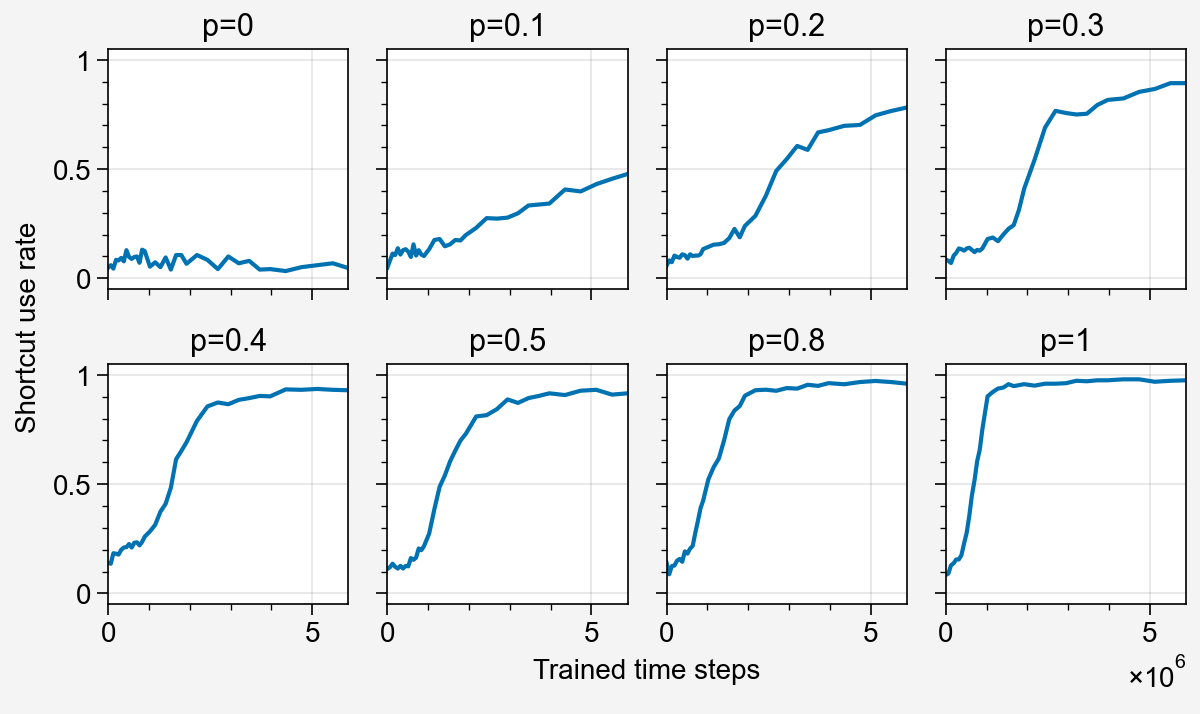

In [62]:
probs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
prob_labels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1]

trials = range(10)
folder = Path('data/shortcut/wc1.5_policy')

summary = pickle.load(open(folder/'summary', 'rb'))

del summary[0.3]['surs'][2]
del summary[0.1]['surs'][8]

fig, ax = pplt.subplots(nrows=2, ncols=4, figwidth=6)

x = chk_sched * 64 * 100
for i, p in enumerate(probs):
    x_plot = x
    if i in [0, 1, 2, 4, 5, 6]:
        x_plot = x_plot / 1000000

    lines = []
    lines.append(ax[i].plot(x_plot, np.mean(summary[p]['surs'], axis=0), label='Shortcut use rate'))

ax.format(xlabel='Trained time steps', ylabel='Shortcut use rate',
          title=[f'p={p}' for p in prob_labels], ylim=[-0.05, 1.05])
fig.savefig(save/'2_1_p_shortcut_use_curves')

meta NOT subset; don't know how to subset; dropped


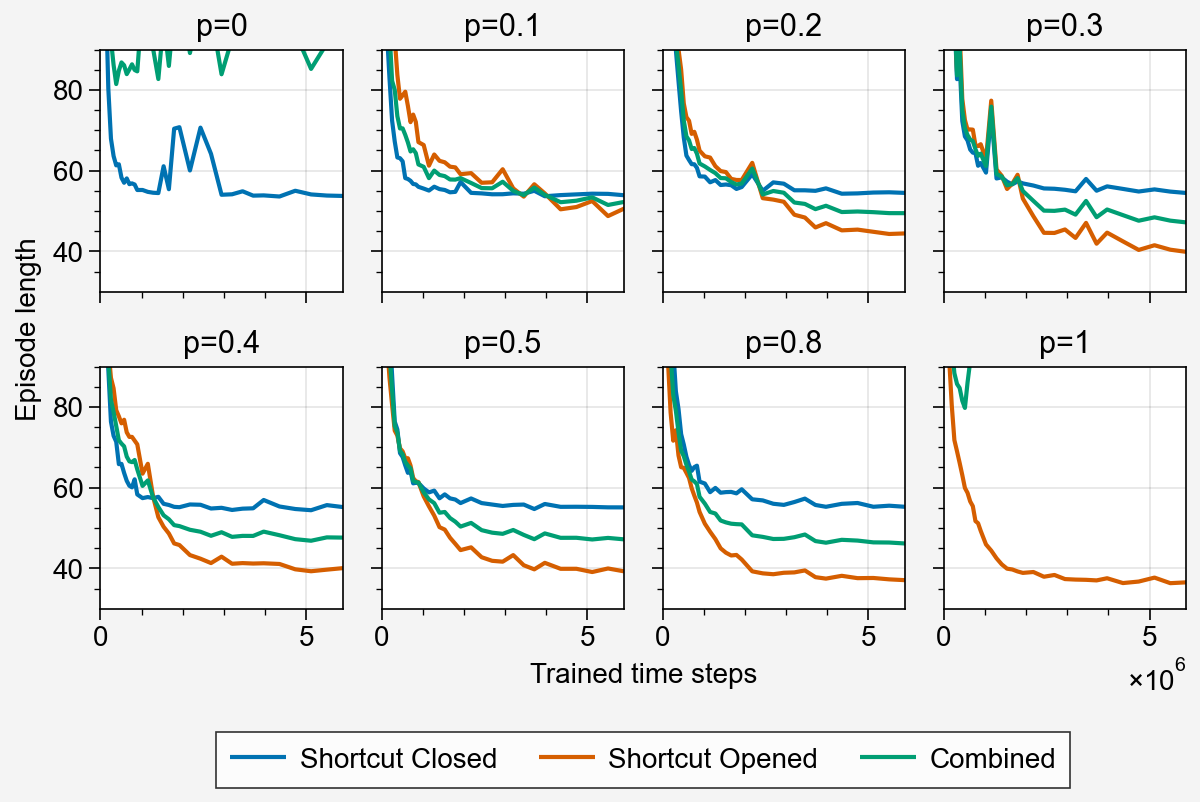

In [63]:
probs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
prob_labels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1]
trials = range(10)
folder = Path('data/shortcut/wc1.5_policy')

summary = pickle.load(open(folder/'summary', 'rb'))

fig, ax = pplt.subplots(nrows=2, ncols=4, figwidth=6)

x = chk_sched * 64 * 100
for i, p in enumerate(probs):
    lines = []
    x_plot = x
    if i in [0, 1, 2, 4, 5, 6]:
        x_plot = x_plot / 1000000
    
    if p == 0.3:
        for key in ['ns_lens', 'ws_lens', 'comb_lens', 'surs']:
            del summary[p][key][2]
    if p == 0.1:
        for key in ['ns_lens', 'ws_lens', 'comb_lens', 'surs']:
            del summary[p][key][8]
    
    lines.append(ax[i].plot(x_plot, np.mean(summary[p]['ns_lens'], axis=0), label='Shortcut Closed'))
    lines.append(ax[i].plot(x_plot, np.mean(summary[p]['ws_lens'], axis=0), label='Shortcut Opened'))
    lines.append(ax[i].plot(x_plot, np.mean(summary[p]['comb_lens'], axis=0), label='Combined'))

fig.legend(lines, loc='b')
ax.format(xlabel='Trained time steps', ylabel='Episode length',
          title=[f'p={p}' for p in prob_labels], ylim=[30, 90])
fig.savefig(save/'2_1_p_performance_curves_zoomed')

## Comparison of open vs closed performancce and relation to shortcut use

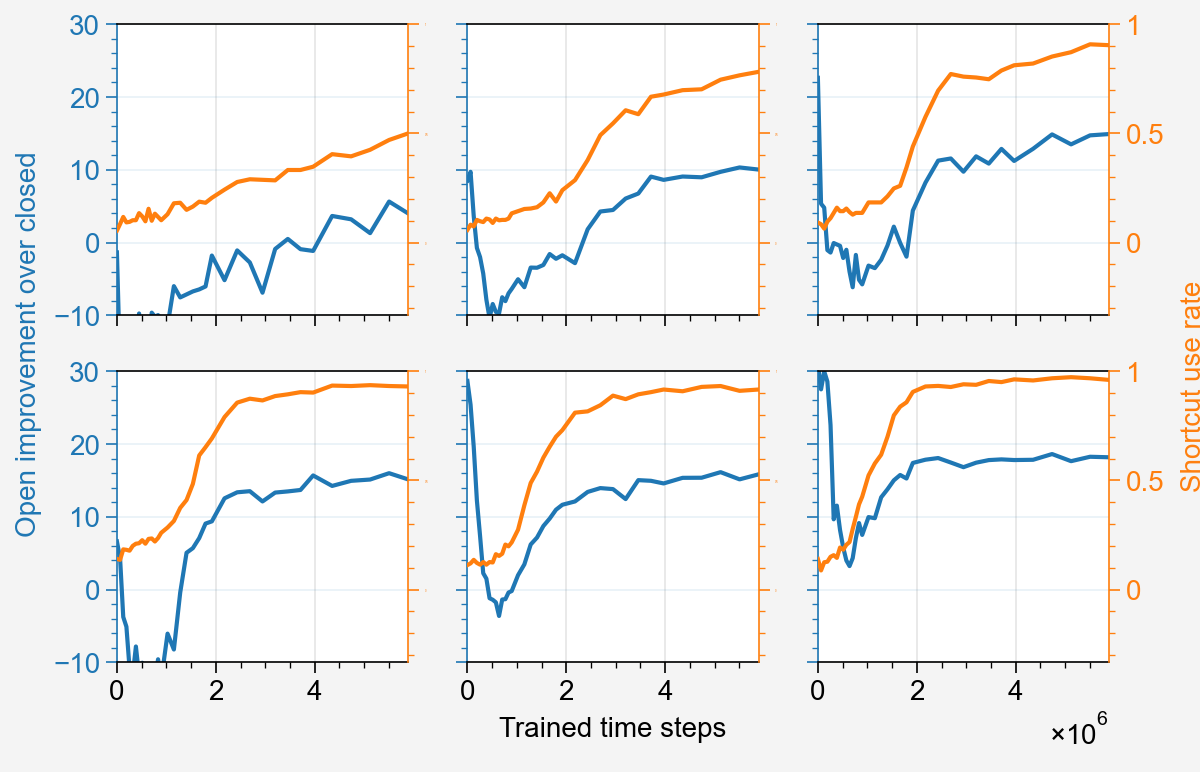

In [64]:
probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]

fig, ax = pplt.subplots(nrows=2, ncols=3, figwidth=6)
sax = ax.dualy(lambda x: x / 30)

for i, p in enumerate(probs):
    x = [] # ws vs ns difference
    y = [] # sur
    
    if p == 0.3:
        for key in ['ns_lens', 'ws_lens', 'comb_lens', 'surs']:
            del summary[p][key][2]
    if p == 0.1:
        for key in ['ns_lens', 'ws_lens', 'comb_lens', 'surs']:
            del summary[p][key][8]


    diff = np.array(summary[p]['ns_lens']) - np.array(summary[p]['ws_lens'])
    y1 = diff.mean(axis=0)
    y2 = np.mean(summary[p]['surs'], axis=0)
    
    x = chk_sched * 64 * 100
    if i in [0, 1, 3, 4]:
        x = x / 1000000

    ax[i].plot(x, y1, c=rgb_colors[0])
    sax[i].plot(x, y2, c=rgb_colors[1])

ax.format(ylabel='Open improvement over closed', ylabelcolor=rgb_colors[0], ylim=[-10, 30],
          ytickcolor=rgb_colors[0], yticklabelcolor=rgb_colors[0], ygridcolor=rgb_colors[0],
          xlabel='Trained time steps')
sax.format(ylabelcolor=rgb_colors[1],
          ytickcolor=rgb_colors[1], yticklabelcolor=rgb_colors[1], ygridcolor=rgb_colors[1])

for a in ax:
    a.spines['left'].set_color(rgb_colors[0])
for a in sax:
    a.spines['right'].set_color(rgb_colors[1])

fig.text(0.995, 0.5, 'Shortcut use rate', rotation=90, 
         transform=fig.transFigure, ha='center',
         va='center', color=rgb_colors[1]
)
sax[:, :2].format(fontsize=0)

meta NOT subset; don't know how to subset; dropped


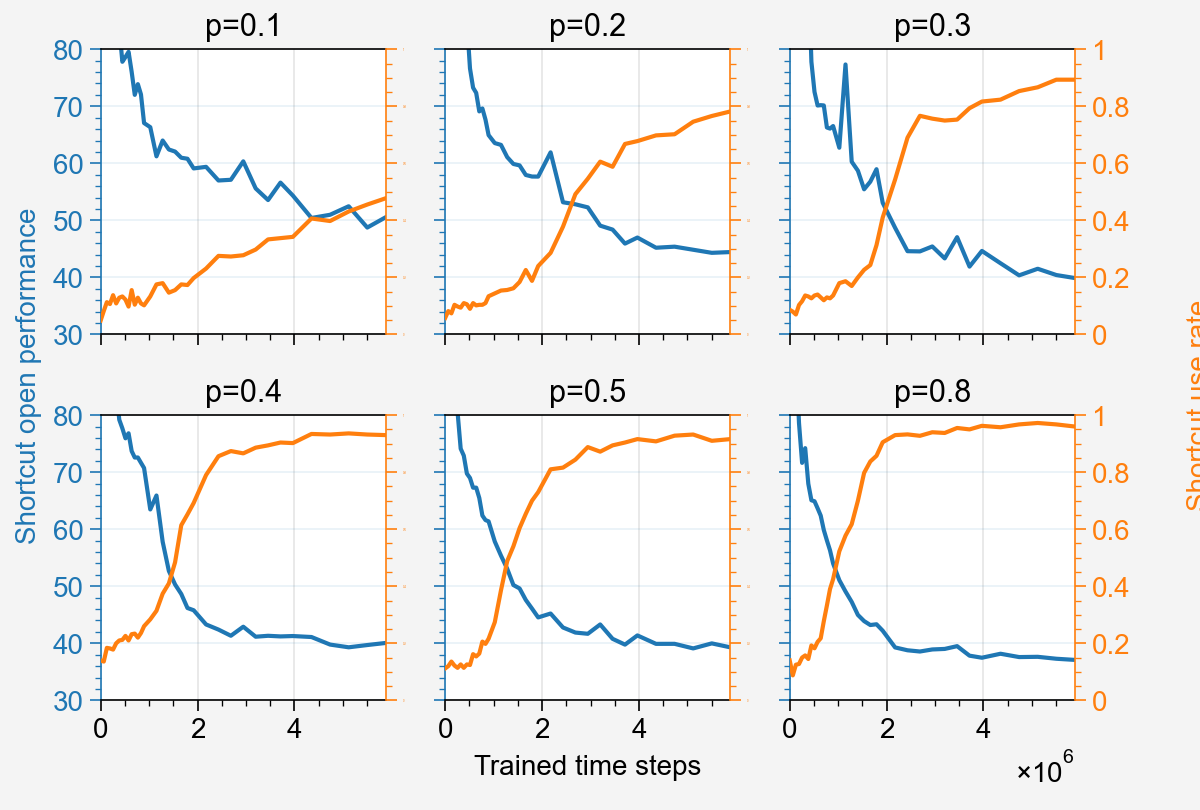

In [65]:
probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]
folder = Path('data/shortcut/wc1.5_policy')

summary = pickle.load(open(folder/'summary', 'rb'))

fig, ax = pplt.subplots(nrows=2, ncols=3, figwidth=6)
sax = ax.dualy(lambda x: (x-30) / 50)

for i, p in enumerate(probs):
    x = chk_sched * 64 * 100
    if i in [0, 1, 3, 4]:
        x = x / 1000000
    if p == 0.3:
        for key in ['ns_lens', 'ws_lens', 'comb_lens', 'surs']:
            del summary[p][key][2]
    if p == 0.1:
        for key in ['ns_lens', 'ws_lens', 'comb_lens', 'surs']:
            del summary[p][key][8]
    y0 = np.mean(summary[p]['ws_lens'], axis=0)
    y1 = np.mean(summary[p]['surs'], axis=0)

    ax[i].plot(x, y0, c=rgb_colors[0], label='Shortcut Closed')
    sax[i].plot(x, y1, c=rgb_colors[1])

ax.format(ylabel='Shortcut open performance', ylabelcolor=rgb_colors[0],
          ytickcolor=rgb_colors[0], yticklabelcolor=rgb_colors[0], ygridcolor=rgb_colors[0],
          xlabel='Trained time steps',
          ylim=[30, 80], title=[f'p={p}' for p in probs])
sax.format(ylabelcolor=rgb_colors[1],
          ytickcolor=rgb_colors[1], yticklabelcolor=rgb_colors[1], ygridcolor=rgb_colors[1])

for a in ax:
    a.spines['left'].set_color(rgb_colors[0])
for a in sax:
    a.spines['right'].set_color(rgb_colors[1])

fig.text(1, 0.5, 'Shortcut use rate', rotation=90, 
         transform=fig.transFigure, ha='center',
         va='center', color=rgb_colors[1]
)
sax[:, :2].format(fontsize=0)
fig.savefig(save/'2_2_open_performance_sur')

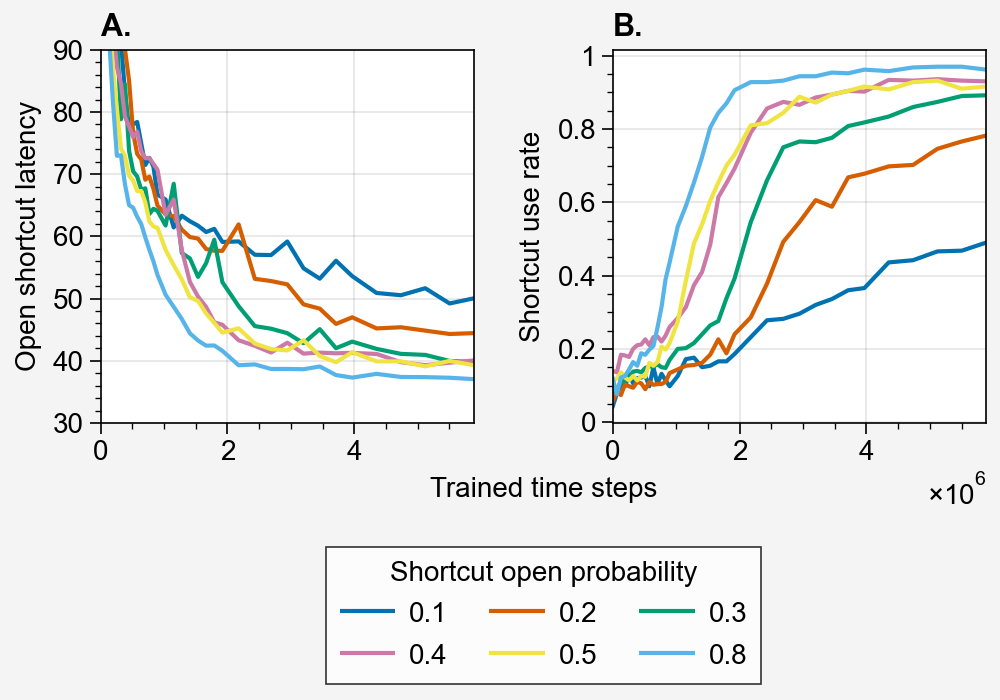

In [17]:
comb_folder = Path('data/shortcut/combined/')
summary = pickle.load(open(comb_folder/'summary', 'rb'))
x = chk_sched*64*100

fig, ax = pplt.subplots(ncols=2, sharey=False, wspace=5, figwidth=5)
probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]

lines = []
for p in probs:
    ws_len = np.array(summary[p]['ws_lens']).mean(axis=0)
    surs = np.array(summary[p]['surs']).mean(axis=0)
    
    lines.append(ax[0].plot(x/1e6, ws_len, label=f'{p}'))
    ax[1].plot(x, surs)
    
fig.legend(lines, loc='b', title='Shortcut open probability')
ax.format(xlabel='Trained time steps', abc='A.')
ax[0].format(ylabel='Open shortcut latency', ylim=[30, 90])
ax[1].format(ylabel='Shortcut use rate')



## Performance and shortcut use rate with pre-training and auxiliary

meta NOT subset; don't know how to subset; dropped


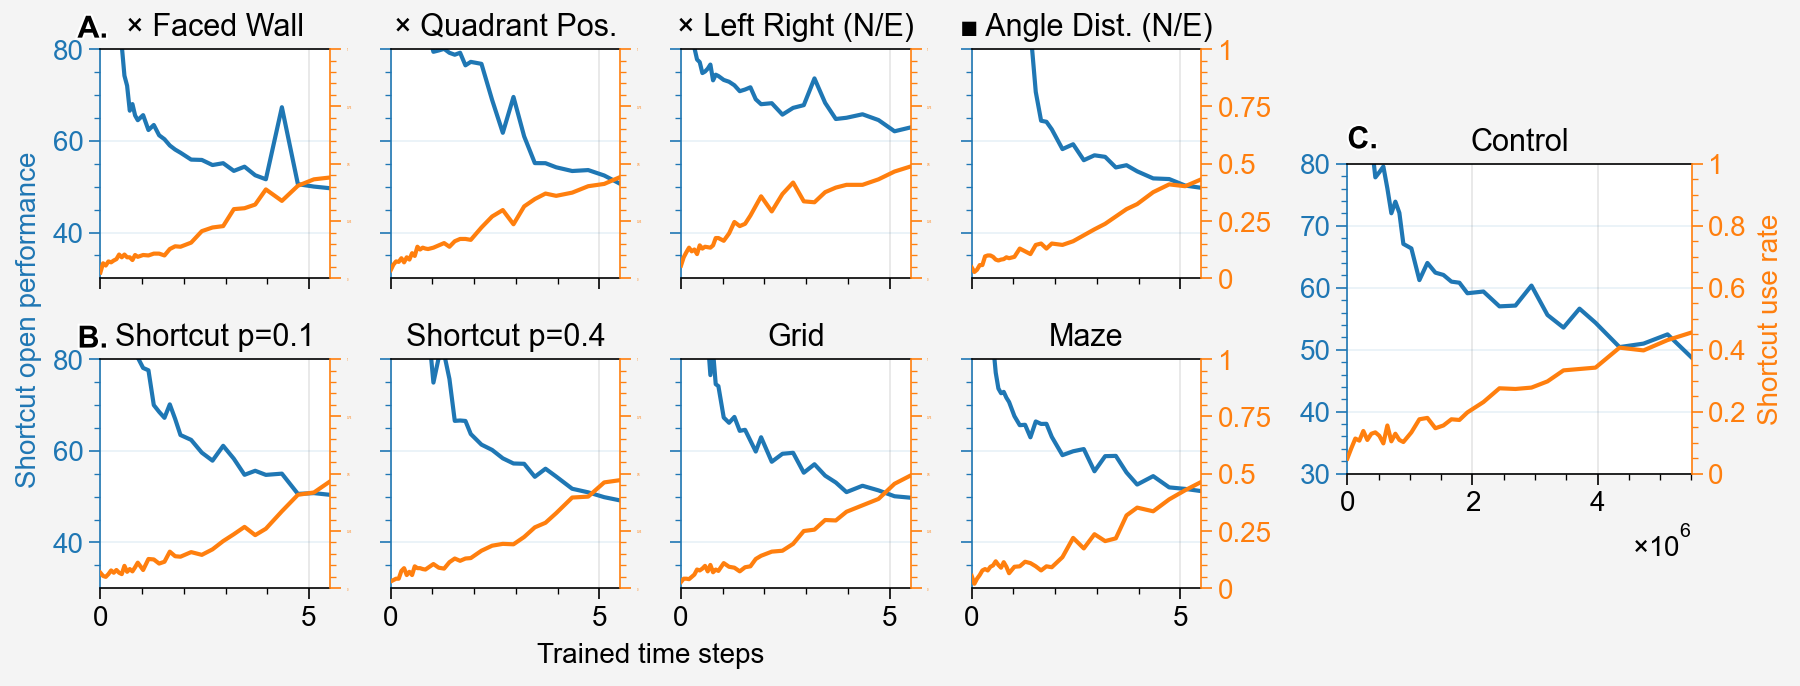

In [66]:
folders = {
    'aux': Path('data/shortcut/sc_aux_policy'),
    'pre': Path('data/shortcut/plum2sc_policy')
}

subsets = {
    'aux': ['catfacewall',  'catquad', 'catwall01', 'wall01'],
    'pre': ['3_0.1_0.1', '3_0.4_0.1', '1.7_0.1', '2.7_0.1']
}

labels = {
    'aux': [u'\u00D7 Faced Wall', u'\u00D7 Quadrant Pos.',
          u'\u00D7 Left Right (N/E)', '\u25A0 Angle Dist. (N/E)'],
    'pre': ['Shortcut p=0.1', 'Shortcut p=0.4', 'Grid', 'Maze']
}

train_types = ['aux', 'pre']

array = [
    [1,1, 2,2, 3,3, 4,4, 0,0,0],
    [1,1, 2,2, 3,3, 4,4, 9,9,9],
    [5,5, 6,6, 7,7, 8,8, 9,9,9],
    [5,5, 6,6, 7,7, 8,8, 0,0,0],
]

fig, axs = pplt.subplots(array, figwidth=9)
saxs = []
all_labels = []

for i, train in enumerate(train_types):
    summary = pickle.load(open(folders[train]/'summary', 'rb'))
    
    for j in range(4):
        ax = axs[i*4 + j]
        sax = ax.dualy(lambda x: (x-30)/50)
        saxs.append(sax)
        subset = subsets[train][j]
        all_labels.append(labels[train][j])
        
        x = chk_sched * 64 * 100 / 1000000
        y0 = np.mean(summary[subset]['ws_lens'], axis=0)
        y1 = np.mean(summary[subset]['surs'], axis=0)
        
        ax.plot(x[:35], y0, c=rgb_colors[0])
        sax.plot(x[:35], y1, c=rgb_colors[1])
        
        sax.format(ycolor=rgb_colors[1])
        if j < 3:
            sax.format(fontsize=0)

        
# Plot control

folder = Path('data/shortcut/wc1.5_policy')
summary = pickle.load(open(folder/'summary', 'rb'))

ax = axs[8]
sax = ax.dualy(lambda x: (x-30)/50)
saxs.append(sax)
x = chk_sched*64*100
p = 0.1
for key in ['ns_lens', 'ws_lens', 'comb_lens', 'surs']:
    del summary[p][key][8]
y0 = np.mean(summary[p]['ws_lens'], axis=0)
y1 = np.mean(summary[p]['surs'], axis=0)
all_labels.append('Control')

ax.plot(x[:35], y0[:35], c=rgb_colors[0])
sax.plot(x[:35], y1[:35], c=rgb_colors[1])

sax.format(ycolor=rgb_colors[1], ylabel='Shortcut use rate')
axs.format(ylabel='Shortcut open performance', ylabelcolor=rgb_colors[0],
          ytickcolor=rgb_colors[0], yticklabelcolor=rgb_colors[0], ygridcolor=rgb_colors[0],
          xlabel='Trained time steps',
          ylim=[30, 80], title=all_labels)
axs.format(ycolor=list(rgb_colors[0]))
axs[-1].format(ylabel='', xlabel='')

for a in axs:
    a.spines['left'].set_color(rgb_colors[0])
for a in saxs:
    a.spines['right'].set_color(rgb_colors[1])

add_abc_to_subaxes(axs[0], 'A.', left=-0.1)
add_abc_to_subaxes(axs[4], 'B.', left=-0.1)
add_abc_to_subaxes(axs[-1], 'C.')
    
fig.savefig(save/'2_3_intervention_open_sur')

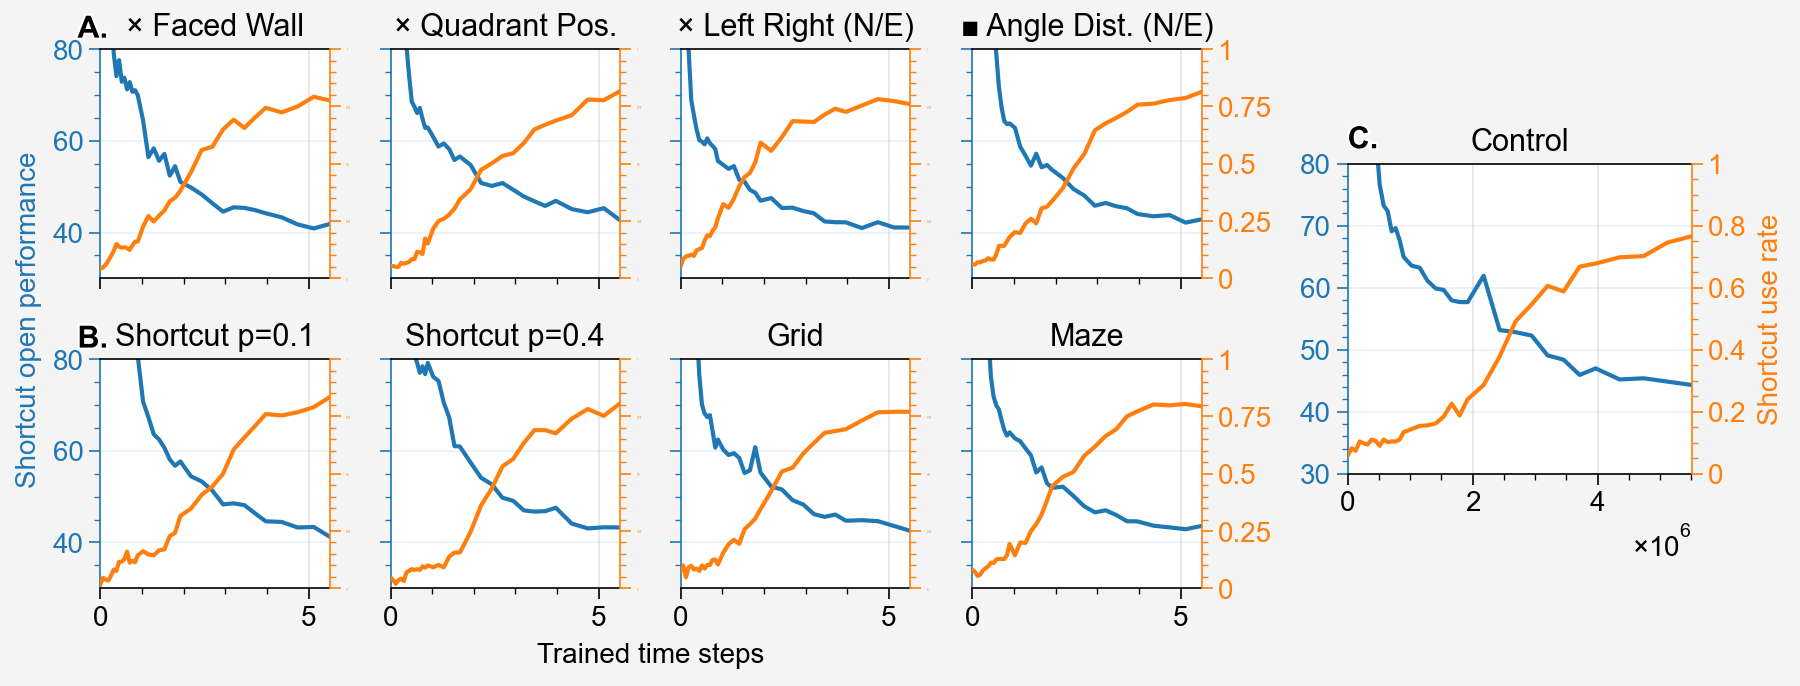

In [16]:
folders = {
    'aux': Path('data/shortcut/sc_aux_policy'),
    'pre': Path('data/shortcut/plum2sc_policy')
}

subsets = {
    'aux': ['0.2_catfacewall',  '0.2_catquad', '0.2_catwall01', '0.2_wall01'],
    'pre': ['3tp0.1_0.2', '3tp0.4_0.2', '1.7_0.2', '2.7_0.2']
}

labels = {
    'aux': [u'\u00D7 Faced Wall', u'\u00D7 Quadrant Pos.',
          u'\u00D7 Left Right (N/E)', '\u25A0 Angle Dist. (N/E)'],
    'pre': ['Shortcut p=0.1', 'Shortcut p=0.4', 'Grid', 'Maze']
}

train_types = ['aux', 'pre']

array = [
    [1,1, 2,2, 3,3, 4,4, 0,0,0],
    [1,1, 2,2, 3,3, 4,4, 9,9,9],
    [5,5, 6,6, 7,7, 8,8, 9,9,9],
    [5,5, 6,6, 7,7, 8,8, 0,0,0],
]

fig, axs = pplt.subplots(array, figwidth=9)
saxs = []
all_labels = []

for i, train in enumerate(train_types):
    summary = pickle.load(open(folders[train]/'0.2_summary', 'rb'))
    
    for j in range(4):
        ax = axs[i*4 + j]
        sax = ax.dualy(lambda x: (x-30)/50)
        saxs.append(sax)
        subset = subsets[train][j]
        all_labels.append(labels[train][j])
        
        x = chk_sched * 64 * 100 / 1000000
        ys = np.full((10, 36), np.nan)
        max_len = max([len(s) for s in summary[subset]['ws_lens']])
        for n, s in enumerate(summary[subset]['ws_lens']):
            ys[n][:len(s)] = s
        y0 = np.nanmean(ys[:, :max_len], axis=0)
        ys = np.full((10, 36), np.nan)
        max_len = max([len(s) for s in summary[subset]['surs']])
        for n, s in enumerate(summary[subset]['surs']):
            ys[n][:len(s)] = s
        y1 = np.nanmean(ys[:, :max_len], axis=0)
        
        ax.plot(x[:len(y0)], y0, c=rgb_colors[0])
        sax.plot(x[:len(y1)], y1, c=rgb_colors[1])
        
        sax.format(ycolor=rgb_colors[1])
        if j < 3:
            sax.format(fontsize=0)

        
# Plot control

folder = Path('data/shortcut/wc1.5_policy')
summary = pickle.load(open(folder/'summary', 'rb'))

ax = axs[8]
sax = ax.dualy(lambda x: (x-30)/50)
saxs.append(sax)
x = chk_sched*64*100
p = 0.2
# for key in ['ns_lens', 'ws_lens', 'comb_lens', 'surs']:
#     del summary[p][key][8]
y0 = np.mean(summary[p]['ws_lens'], axis=0)
y1 = np.mean(summary[p]['surs'], axis=0)
all_labels.append('Control')

ax.plot(x[:35], y0[:35], c=rgb_colors[0])
sax.plot(x[:35], y1[:35], c=rgb_colors[1])

sax.format(ycolor=rgb_colors[1], ylabel='Shortcut use rate')
axs.format(ylabel='Shortcut open performance', ylabelcolor=rgb_colors[0],
          ytickcolor=rgb_colors[0], yticklabelcolor=rgb_colors[0], ygridcolor=rgb_colors[0],
          xlabel='Trained time steps',
          ylim=[30, 80], title=all_labels)
axs.format(ycolor=list(rgb_colors[0]))
axs[-1].format(ylabel='', xlabel='')

for a in axs:
    a.spines['left'].set_color(rgb_colors[0])
for a in saxs:
    a.spines['right'].set_color(rgb_colors[1])

add_abc_to_subaxes(axs[0], 'A.', left=-0.1)
add_abc_to_subaxes(axs[4], 'B.', left=-0.1)
add_abc_to_subaxes(axs[-1], 'C.')
    
# fig.savefig(save/'2_3_intervention_open_sur')

## Combined performance curves

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


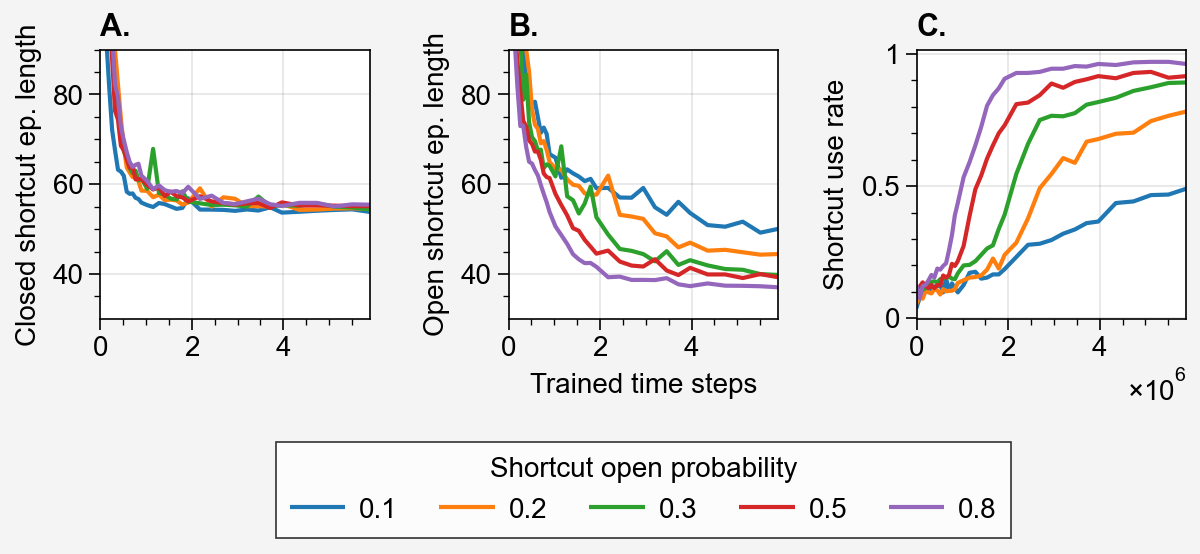

In [4]:
comb_folder = Path('data/shortcut/combined/')
summary = pickle.load(open(comb_folder/'summary', 'rb'))
x = chk_sched*64*100

fig, ax = pplt.subplots(ncols=3, sharey=False, wspace=5, figwidth=6)
probs = [0.1, 0.2, 0.3, 0.5, 0.8]

lines = []
for n, p in enumerate(probs):
    ns_len = np.array(summary[p]['ns_lens']).mean(axis=0)
    ws_len = np.array(summary[p]['ws_lens']).mean(axis=0)
    surs = np.array(summary[p]['surs']).mean(axis=0)
    
    color = rgb_colors[n]
    
    ax[0].plot(x/1e6, ns_len, color=color)
    lines.append(ax[1].plot(x/1e6, ws_len, label=f'{p}', color=color))
    ax[2].plot(x, surs, color=color)
    
fig.legend(lines, loc='b', title='Shortcut open probability', ncols=6)
ax.format(xlabel='Trained time steps', abc='A.')
ax[0].format(ylabel='Closed shortcut ep. length', ylim=[30, 90])
ax[1].format(ylabel='Open shortcut ep. length', ylim=[30, 90])
ax[2].format(ylabel='Shortcut use rate')

fig.savefig(save/'2_4_combined_learning_curves')

### With std cloud

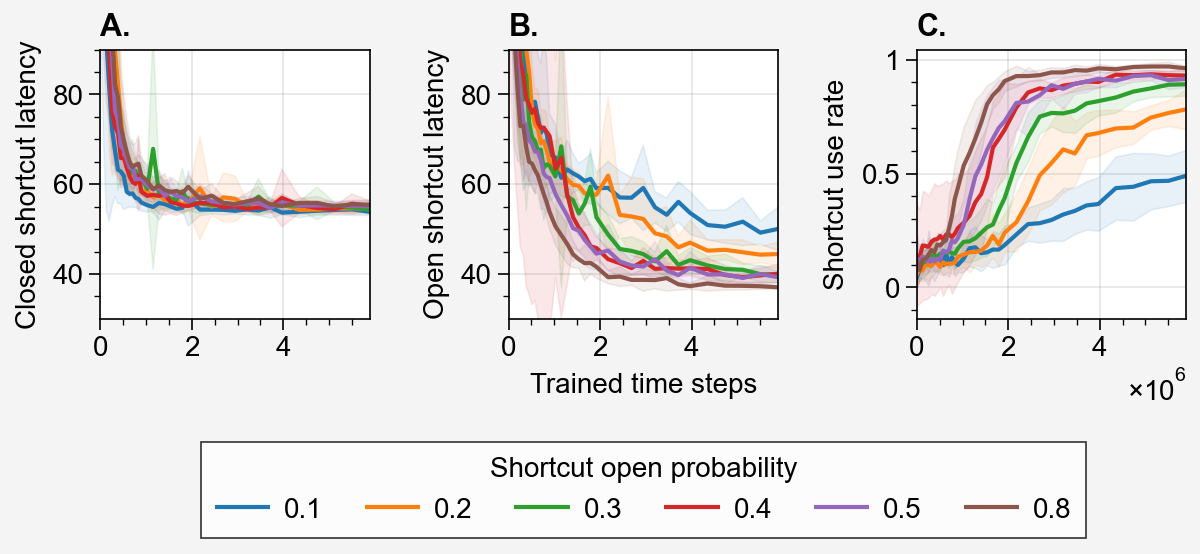

In [5]:
comb_folder = Path('data/shortcut/combined/')
summary = pickle.load(open(comb_folder/'summary', 'rb'))
x = chk_sched*64*100

fig, ax = pplt.subplots(ncols=3, sharey=False, wspace=5, figwidth=6)
probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]

lines = []
for n, p in enumerate(probs):
    keys = ['ns_lens', 'ws_lens', 'surs']
    color = rgb_colors[n]
    
    for i, key in enumerate(keys):
        y = np.array(summary[p][key])
        std = y.std(axis=0)
        mean = y.mean(axis=0)
        mins, maxs = mean-std, mean+std
        
        x = chk_sched*64*100
        if i != 2:
            x = x/1e6
        
        line = ax[i].plot(x, mean, color=color, label=f'{p}')
        ax[i].fill_between(x, mins, maxs, alpha=0.1, color=color)
        
        if i == 2:
            lines.append(line)
            
fig.legend(lines, loc='b', title='Shortcut open probability', ncols=6)
ax.format(xlabel='Trained time steps', abc='A.')
ax[0].format(ylabel='Closed shortcut latency', ylim=[30, 90])
ax[1].format(ylabel='Open shortcut latency', ylim=[30, 90])
ax[2].format(ylabel='Shortcut use rate')



# Individual Node Representations

In [32]:
folder = Path('data/shortcut/wc1.5_policy')
all_hms = pickle.load(open(folder/'spatial_hms', 'rb'))

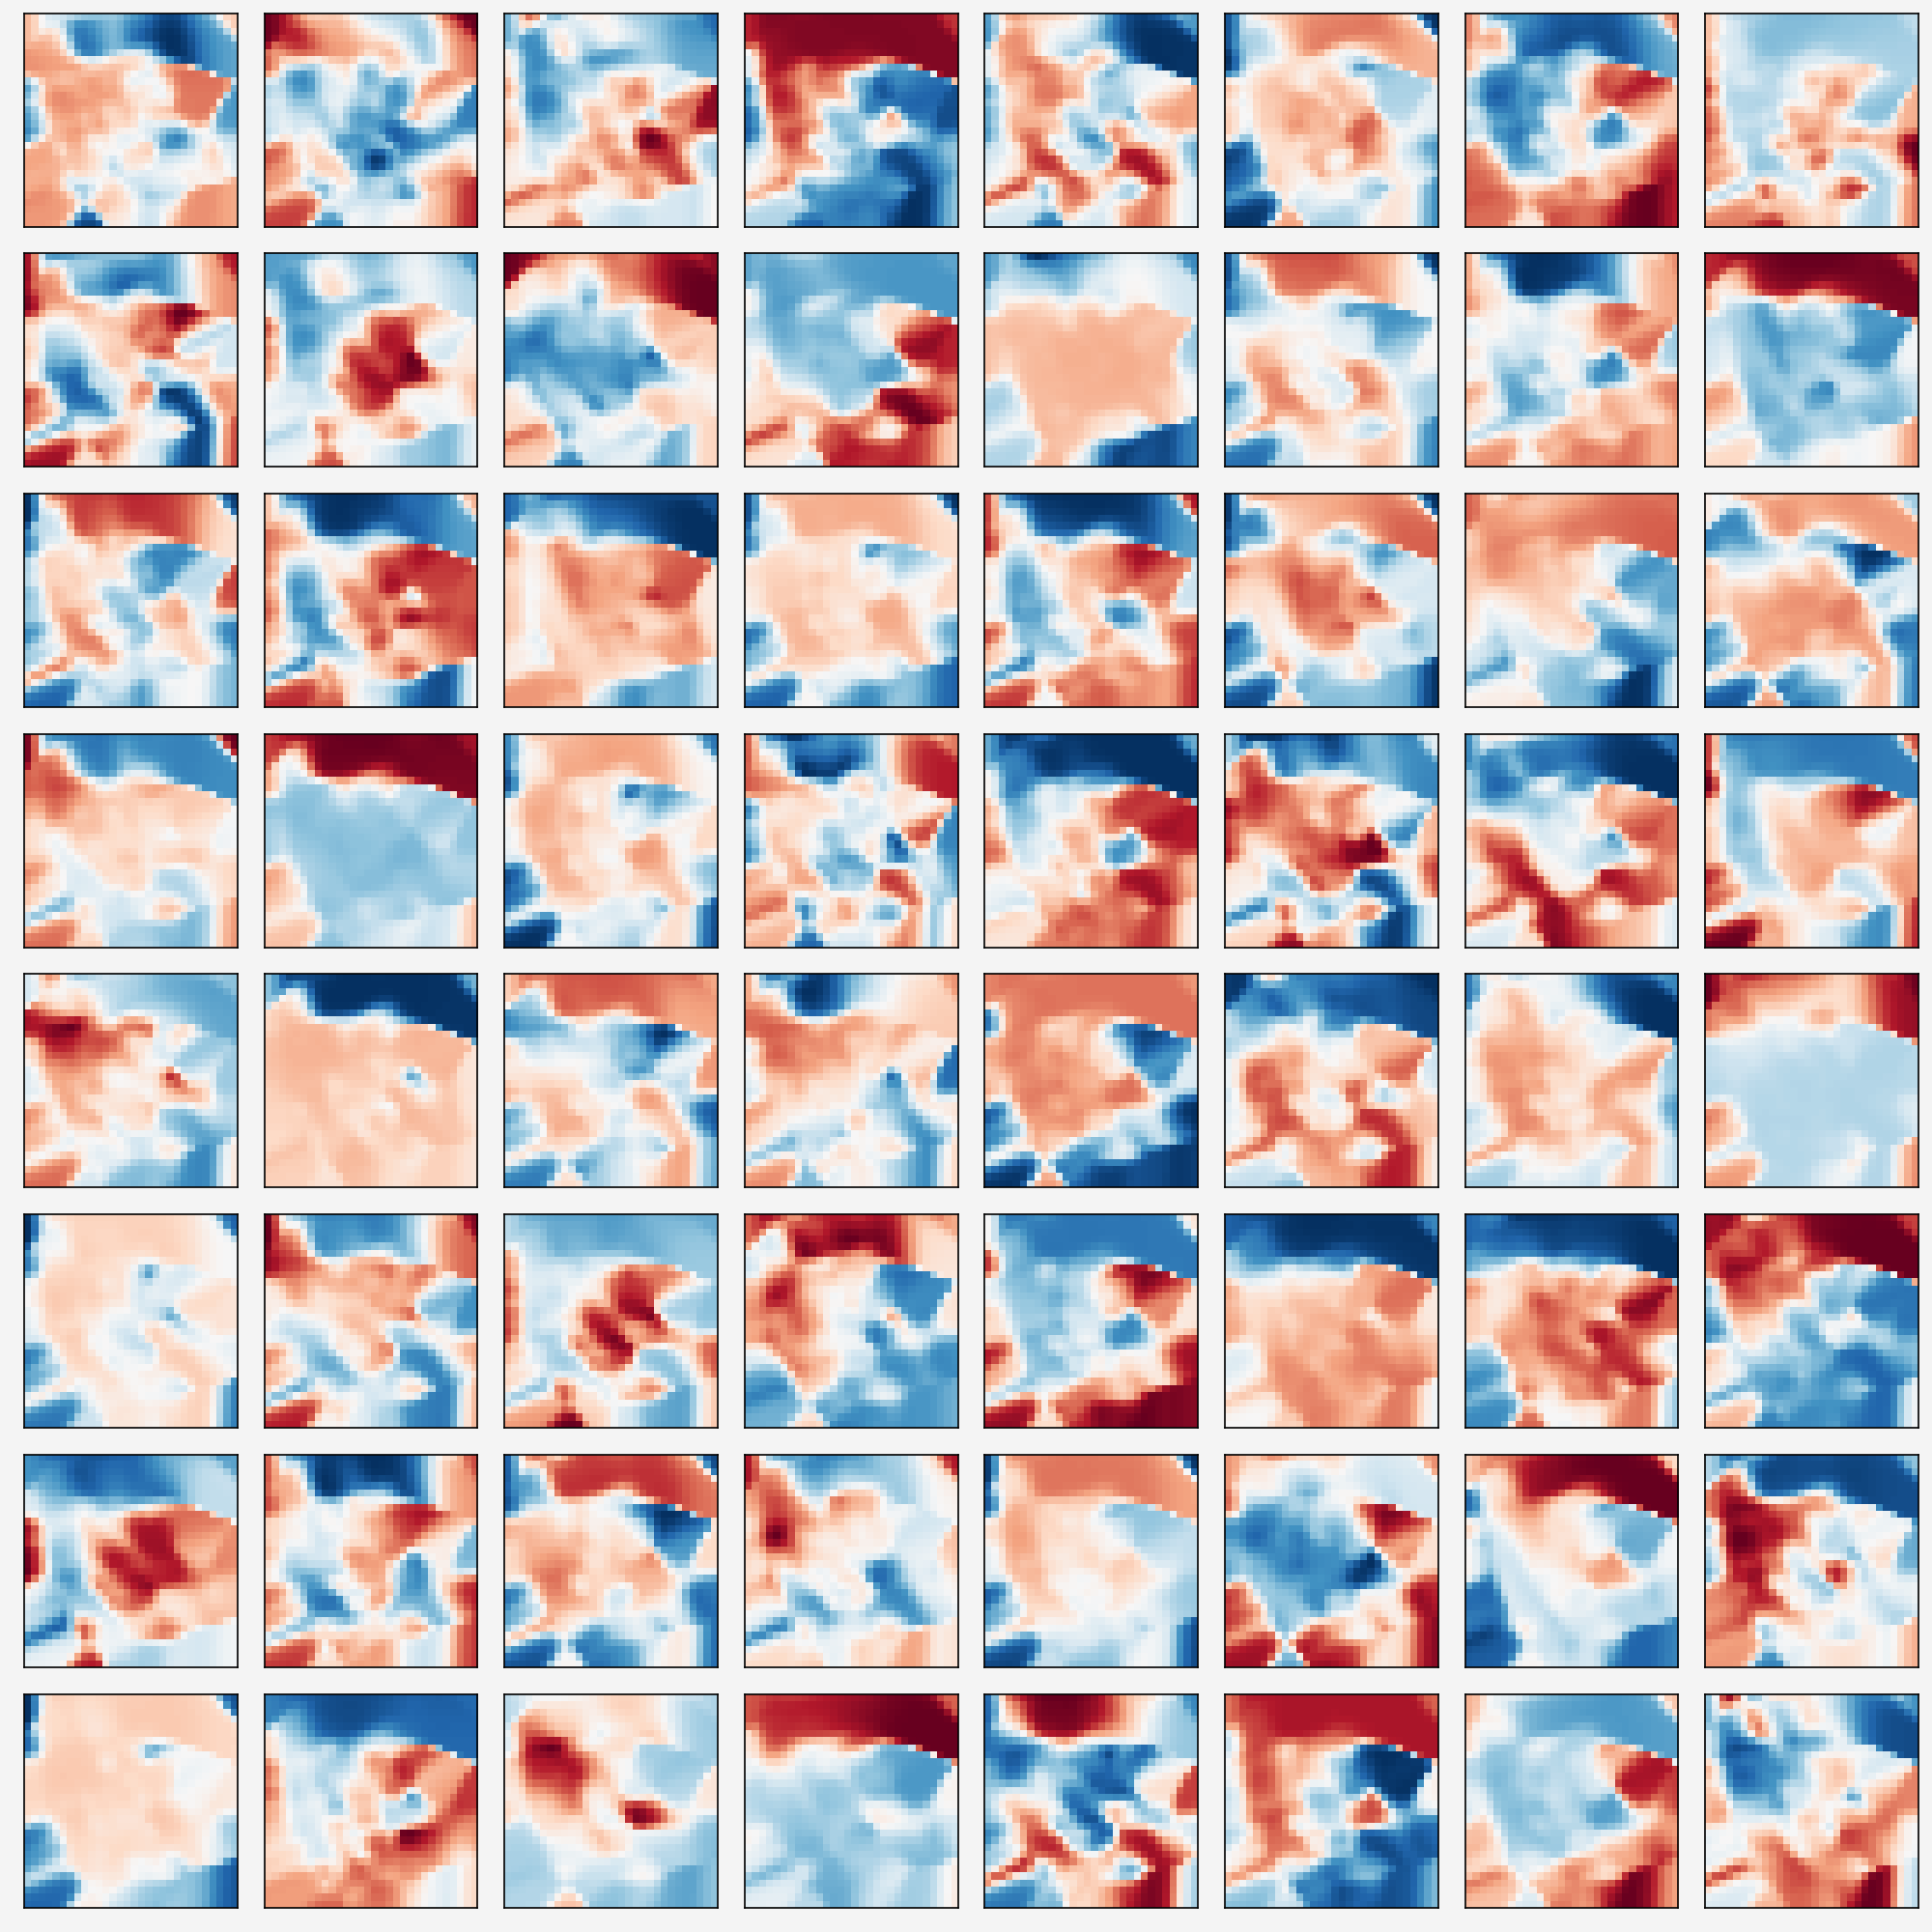

In [33]:
fig, ax = pplt.subplots(nrows=8, ncols=8, wspace=1, hspace=1, figwidth=10)
p = 0.5
t = 7
chk = 15
hms = all_hms[p][t, chk]
for i in range(64):
    ax[i].imshow(hms[i])
    
ax.format(xticks=[], yticks=[])

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


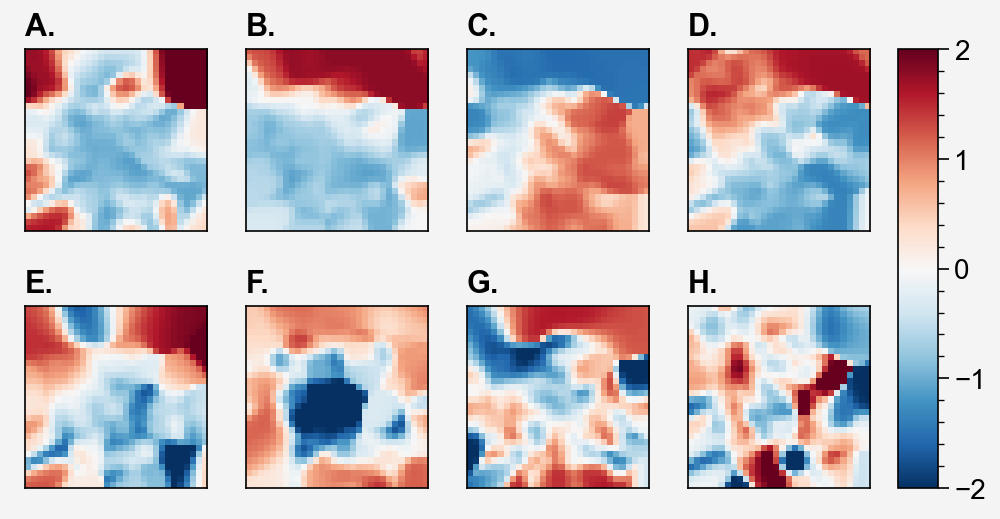

In [26]:
hm_ps = [0.1, 0.4, 0.8, 0.5, 0.1, 0.3, 0.2, 0.8]
hm_ts = [2, 2, 5, 7, 0, 8, 3, 5]
hm_chks = [35, 35, 10, 15, 5, 5, 15, 10]
hm_idxs = [50, 11, 21, 47, 7, 26, 27, 56]

fig, ax = pplt.subplots(nrows=2, ncols=4, figwidth=5)

for i in range(len(hm_ps)):
    hm = all_hms[hm_ps[i]][hm_ts[i], hm_chks[i], hm_idxs[i]]
    cb = ax[i].imshow(hm, vmin=-2, vmax=2)

ax.format(xticks=[], yticks=[], abc='A.')
fig.colorbar(cb)
fig.savefig(save/'3_example_spatial_heatmaps')

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


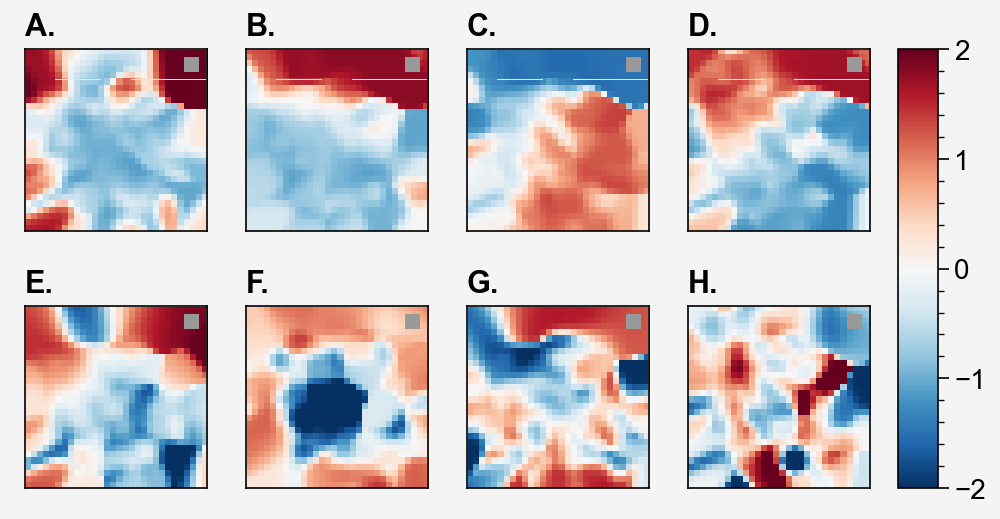

In [29]:
hm_ps = [0.1, 0.4, 0.8, 0.5, 0.1, 0.3, 0.2, 0.8]
hm_ts = [2, 2, 5, 7, 0, 8, 3, 5]
hm_chks = [35, 35, 10, 15, 5, 5, 15, 10]
hm_idxs = [50, 11, 21, 47, 7, 26, 27, 56]

fig, ax = pplt.subplots(nrows=2, ncols=4, figwidth=5)

for i in range(len(hm_ps)):
    hm = all_hms[hm_ps[i]][hm_ts[i], hm_chks[i], hm_idxs[i]]
    cb = ax[i].imshow(hm, vmin=-2, vmax=2, extent=(0, 300, 0, 300))
    draw_shortcut_maze(ax=ax[i])
ax.format(xticks=[], yticks=[], abc='A.')
fig.colorbar(cb)
fig.savefig(save/'3_example_spatial_heatmaps')

## Local variance

### Demonstration

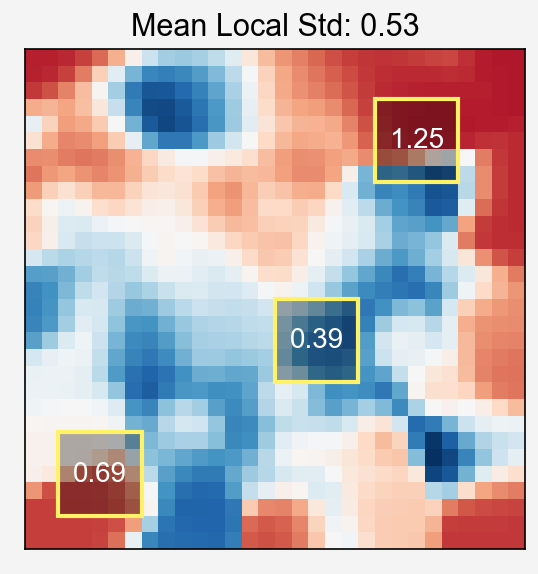

In [5]:
fig, ax = pplt.subplots()
hm = all_hms[0.8][0][20][49]
window_size = 5

v = local_variability(hm.reshape(1, 30, 30), window_size)
title = f'Mean Local Std: {v.item():.2f}'
ax.imshow(hm)

window = get_sliding_window_vector(window_size)
windowx, windowy = window
windowed_hms = hm[windowx, windowy]
stds = np.std(windowed_hms, axis=1)
stds = stds.reshape(30-window_size+1, 30-window_size+1).T

windows = [[4, 25], [23, 5], [17, 17]]
window_diff = (window_size - 1) // 2
for window in windows:
    xy = [window[0]-window_diff-0.5, window[1]-window_diff-0.5]
    rect = plt.Rectangle(xy, window_size, window_size, fc=(0, 0, 0, 0.3),
                        ec=(1, 0.95, 0.4, 1), lw=1.5)
    ax.add_patch(rect)
    i, j = window[1]-window_diff, window[0]-window_diff
    std = stds[i, j]
    ax.text(window[0], window[1], f'{std:.2f}', ha='center', va='center', c='white')

ax.format(title=title, xticks=[], yticks=[])

meta NOT subset; don't know how to subset; dropped


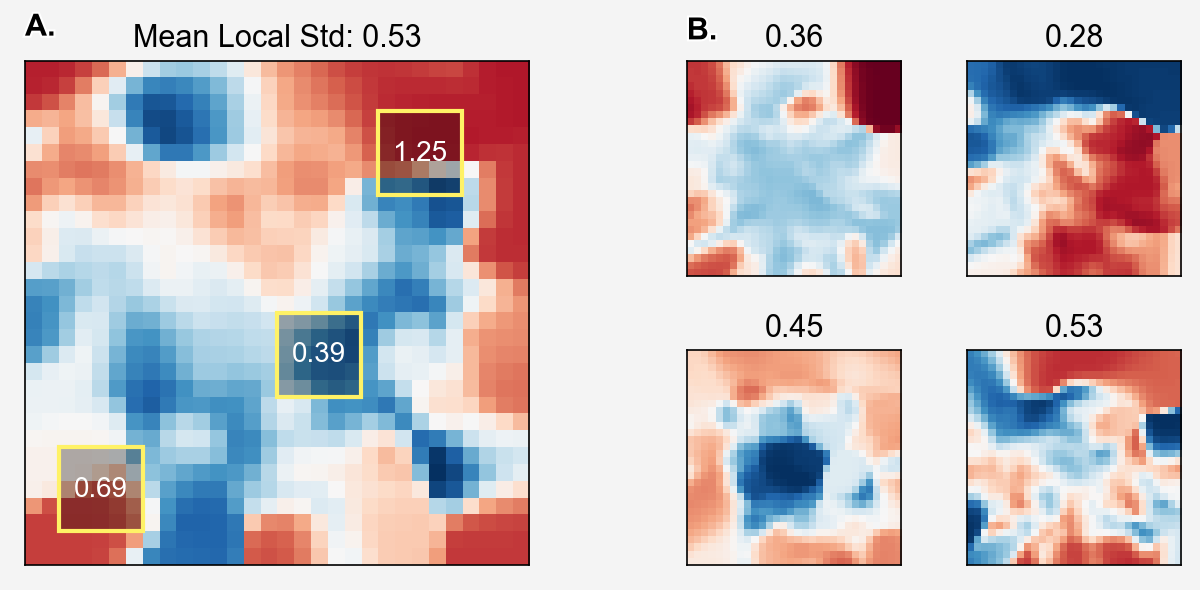

In [33]:
hm_ps = [0.1, 0.8, 0.1, 0.2]
hm_ts = [2, 5, 0, 3]
hm_chks = [35, 10, 5, 15]
hm_idxs = [50, 21, 7, 27]

hm_ps = [0.1, 0.8, 0.3, 0.2]
hm_ts = [2, 5, 8, 3]
hm_chks = [35, 10, 5, 15]
hm_idxs = [50, 21, 26, 27]


array = [
    [1,1, 2, 3,],
    [1,1, 4, 5,],
]

fig, ax = pplt.subplots(array, figwidth=6, wspace=(0, 5, 1))
title = []

# Large demonstration
hm = all_hms[0.8][0, 20, 49]
window_size = 5

v = local_variability(hm.reshape(1, 30, 30), window_size)
ax[0].imshow(hm)
title.append(f'Mean Local Std: {v.item():.2f}')

window = get_sliding_window_vector(window_size)
windowx, windowy = window
windowed_hms = hm[windowx, windowy]
stds = np.std(windowed_hms, axis=1)
stds = stds.reshape(30-window_size+1, 30-window_size+1).T

windows = [[4, 25], [23, 5], [17, 17]]
window_diff = (window_size - 1) // 2
for window in windows:
    xy = [window[0]-window_diff-0.5, window[1]-window_diff-0.5]
    rect = plt.Rectangle(xy, window_size, window_size, fc=(0, 0, 0, 0.3),
                        ec=(1, 0.95, 0.4, 1), lw=1.5)
    ax[0].add_patch(rect)
    i, j = window[1]-window_diff, window[0]-window_diff
    std = stds[i, j]
    ax[0].text(window[0], window[1], f'{std:.2f}', ha='center', va='center', c='white')

# Small heatmap examples
for i in range(len(hm_ps)):
    hm = all_hms[hm_ps[i]][hm_ts[i], hm_chks[i], hm_idxs[i]]
    v = local_variability(hm.reshape(1, 30, 30), window_size)
    title.append(f'{v.item():.2f}')
    ax[i+1].imshow(hm)

ax.format(title=title, xticks=[], yticks=[])
add_abc_to_subaxes(ax[0], 'A.')
add_abc_to_subaxes(ax[1], 'B.', top=1.1)

fig.savefig(save/'3_1_1_local_variance_example')

### Example local variance of nodes for a single agent

meta NOT subset; don't know how to subset; dropped


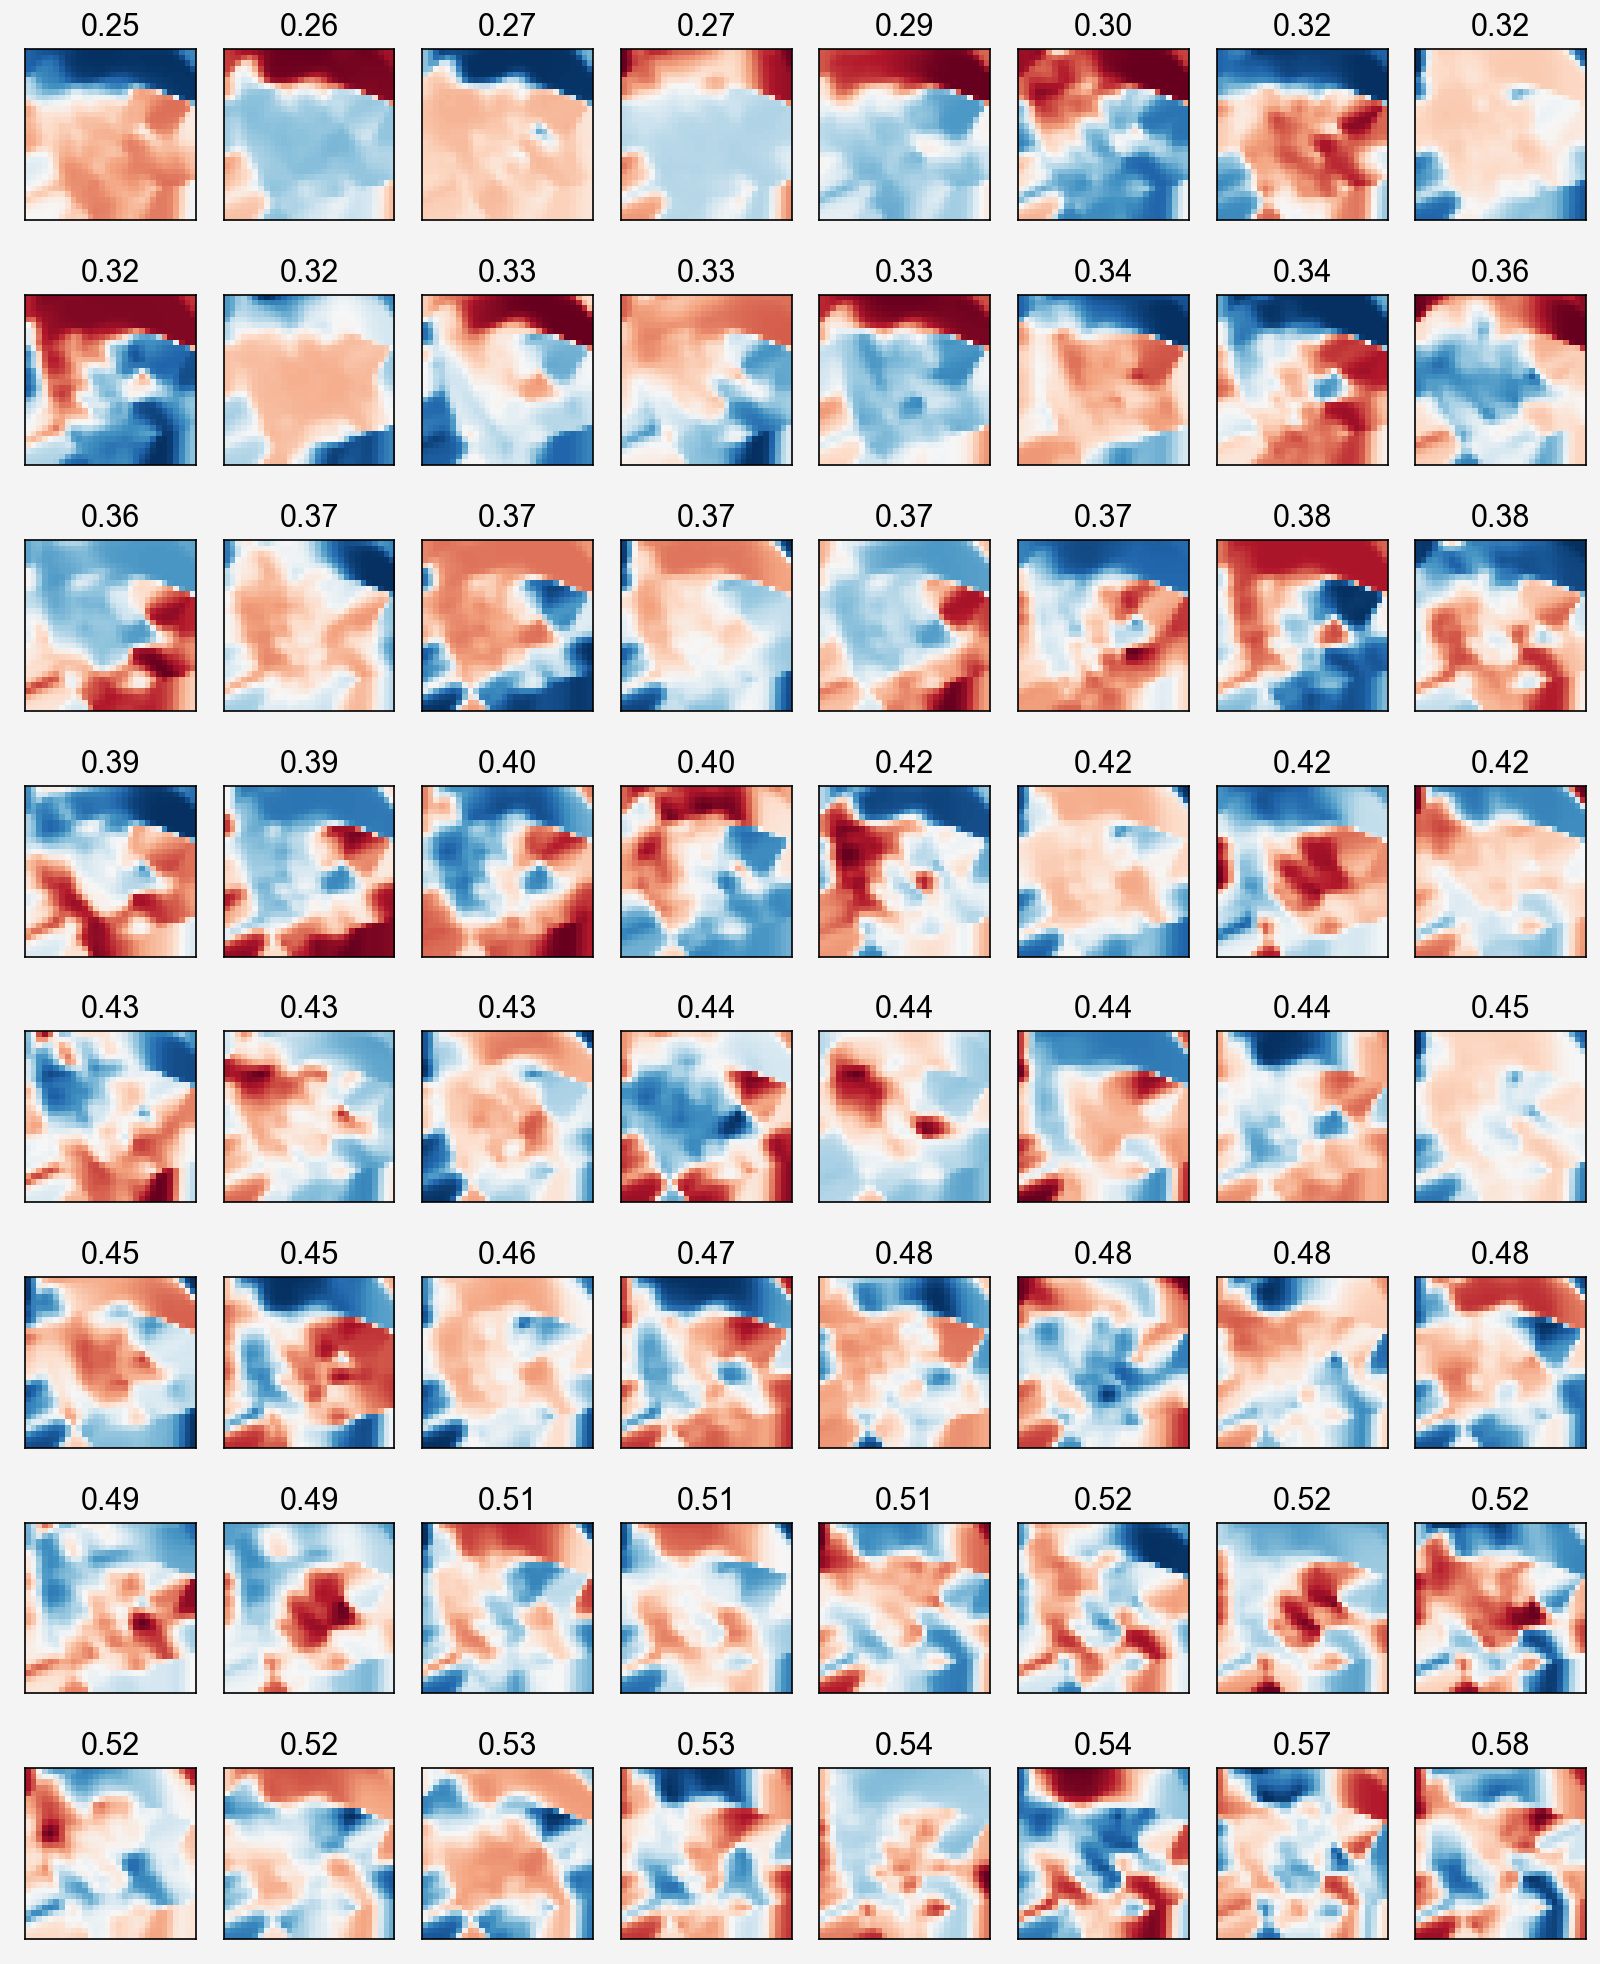

In [34]:
fig, ax = pplt.subplots(nrows=8, ncols=8, wspace=1, figwidth=8)
p = 0.5
t = 7
chk = 15
hms = all_hms[p][t, chk]
stds = local_variability(hms)
idxs = np.argsort(stds)

title = []
for i in range(64):
    ax[i].imshow(hms[idxs[i]])
    title.append(f'{stds[idxs[i]]:.2f}')
    
    
ax.format(xticks=[], yticks=[], title=title)
fig.savefig(save/'3_1_2_oneagent_local_variance_example')

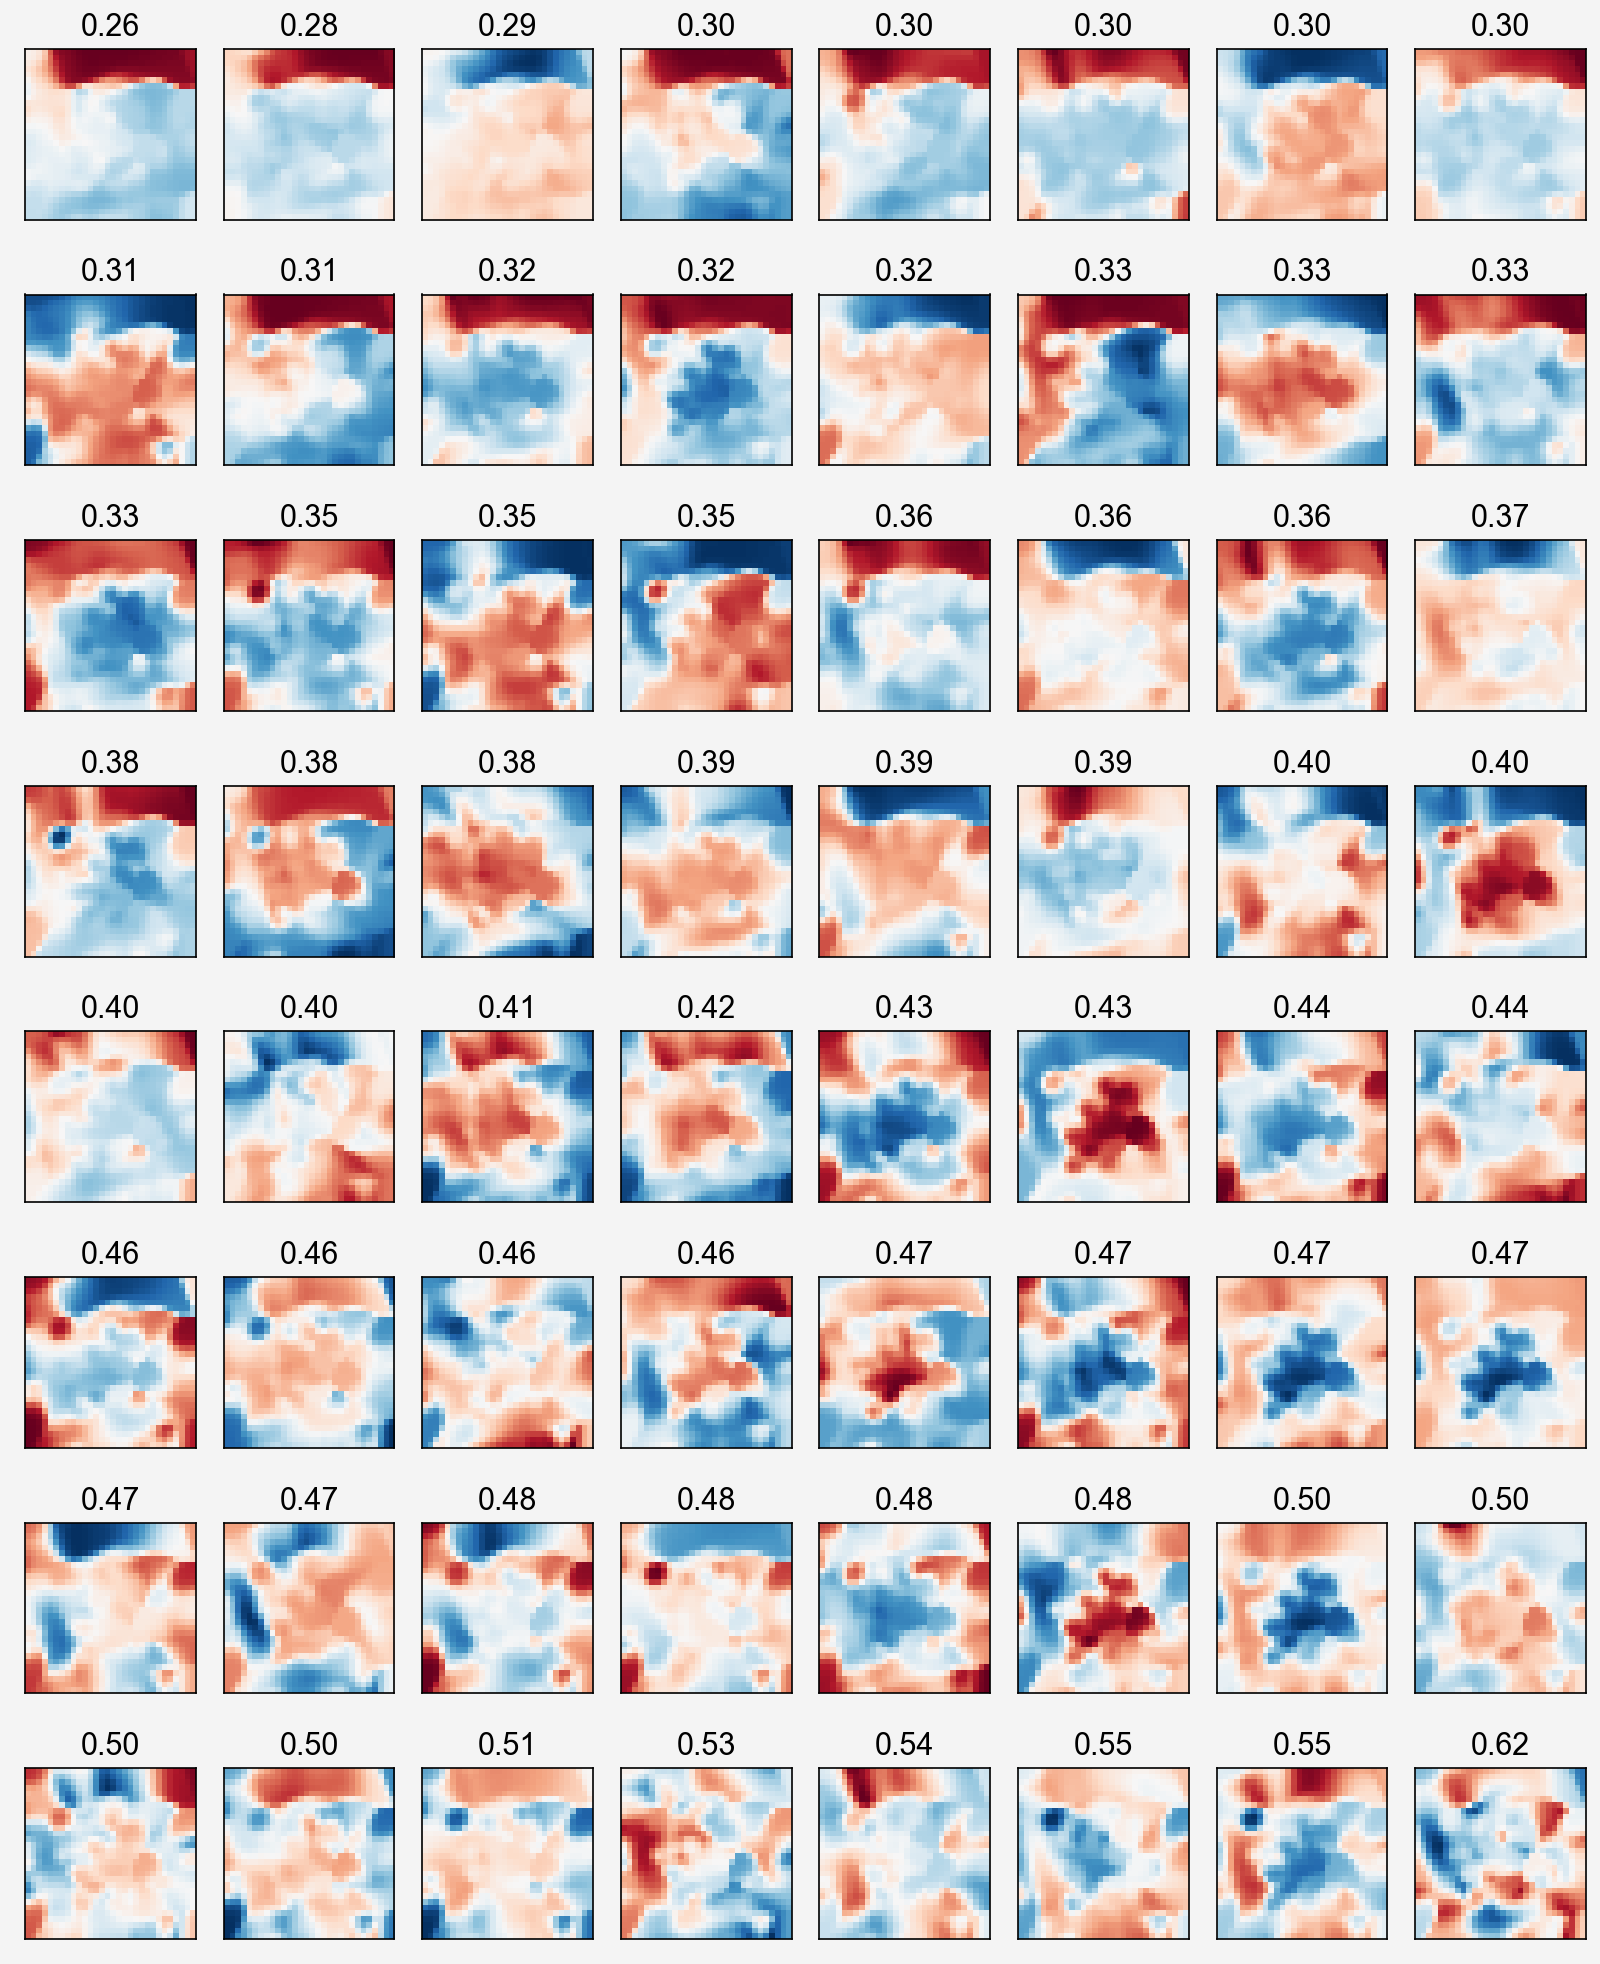

In [33]:
fig, ax = pplt.subplots(nrows=8, ncols=8, wspace=1, figwidth=8)
p = 0.8
t = 7
chk = 5
hms = all_hms[p][t, chk]
stds = local_variability(hms)
idxs = np.argsort(stds)

title = []
for i in range(64):
    ax[i].imshow(hms[idxs[i]])
    title.append(f'{stds[idxs[i]]:.2f}')
    
    
ax.format(xticks=[], yticks=[], title=title)
# fig.savefig(save/'3_1_2_oneagent_local_variance_example')

### Mean local variance across training

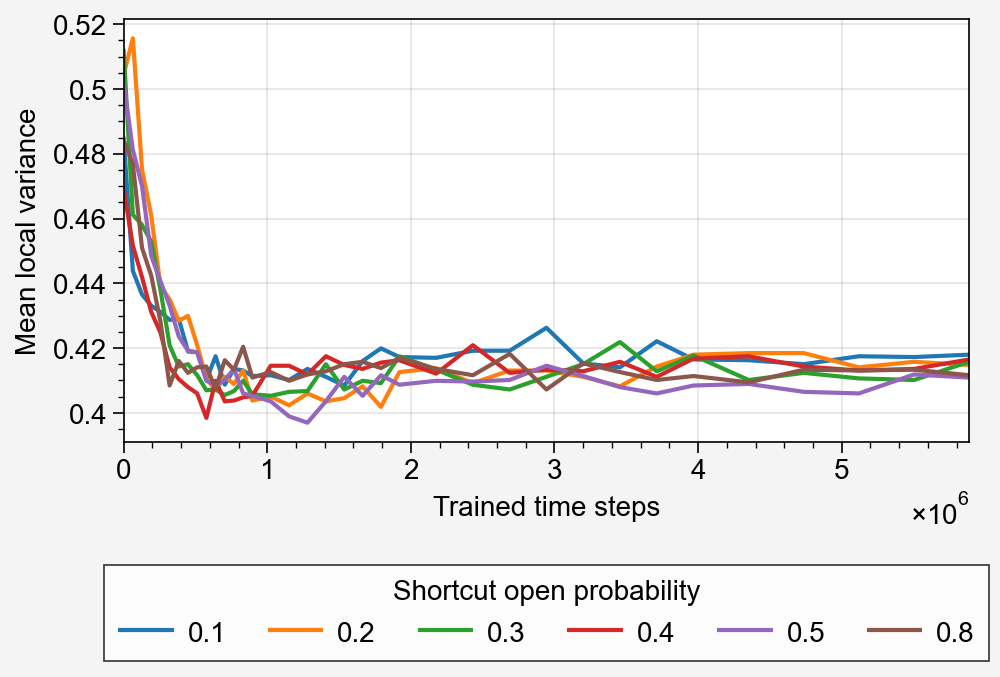

In [75]:
fig, ax = pplt.subplots(refaspect=2, figwidth=5)
lines = []
probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]

for n, p in enumerate(probs):
    color = rgb_colors[n]
    
    y = np.array(all_local_vars[p])
    std = y.std(axis=0).mean(axis=1)
    mean = y.mean(axis=2).mean(axis=0)
    mins, maxs = mean-std, mean+std

    x = chk_sched*64*100
    line = ax.plot(x, mean, color=color, label=f'{p}')
    # ax[i].fill_between(x, mins, maxs, alpha=0.1, color=color)

    lines.append(line)
            
fig.legend(lines, loc='b', title='Shortcut open probability', ncols=6)
ax.format(xlabel='Trained time steps', ylabel='Mean local variance')

#### Mean local variance with closed shortcut latency

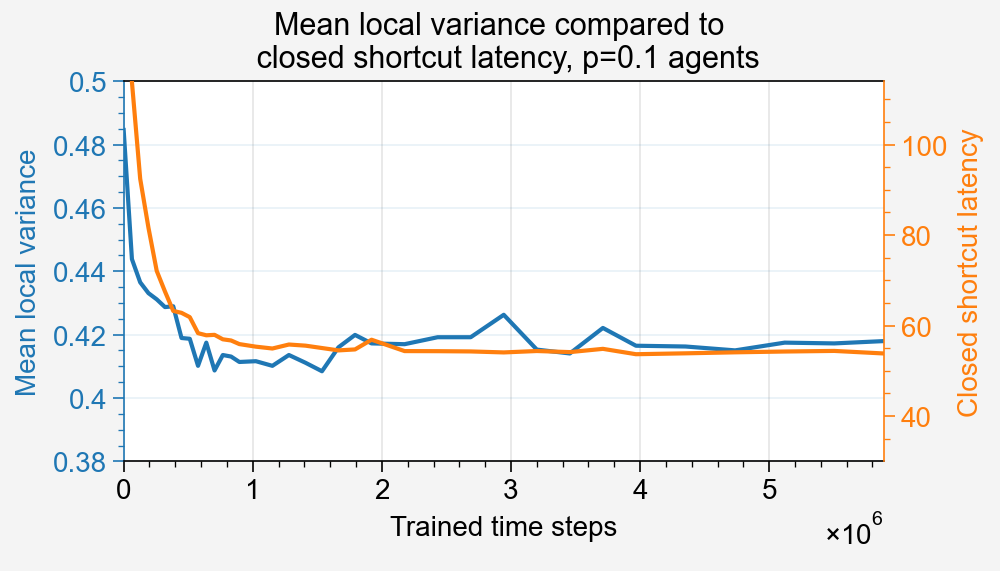

In [87]:
fig, ax = pplt.subplots(refaspect=2, figwidth=5)
sax = ax.dualy(lambda y: (y * 700 - 236))

lines = []
# probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]
probs = [0.1]

for n, p in enumerate(probs):
    color = rgb_colors[0]
    
    y = np.array(all_local_vars[p])
    std = y.std(axis=0).mean(axis=1)
    mean = y.mean(axis=2).mean(axis=0)
    mins, maxs = mean-std, mean+std

    x = chk_sched*64*100
    line = ax.plot(x, mean, color=color, label=f'{p}')
    # ax[i].fill_between(x, mins, maxs, alpha=0.1, color=color)
    lines.append(line)
    
    y = np.array(summary[p]['ns_lens']).mean(axis=0)
    sax.plot(x, y, color=rgb_colors[1])
    
sax.spines['right'].set_color(rgb_colors[1])
ax.spines['left'].set_color(rgb_colors[0])
ax.format(ylabelcolor=rgb_colors[0],
          ytickcolor=rgb_colors[0], yticklabelcolor=rgb_colors[0], ygridcolor=rgb_colors[0])
sax.format(ylabelcolor=rgb_colors[1],
          ytickcolor=rgb_colors[1], yticklabelcolor=rgb_colors[1], ygridcolor=rgb_colors[1])


# fig.legend(lines, loc='b', title='Shortcut open probability', ncols=6)
ax.format(xlabel='Trained time steps', ylabel='Mean local variance', ylim=[0.38, 0.5],
         title='Mean local variance compared to \n closed shortcut latency, p=0.1 agents')
sax.format(ylabel='Closed shortcut latency')

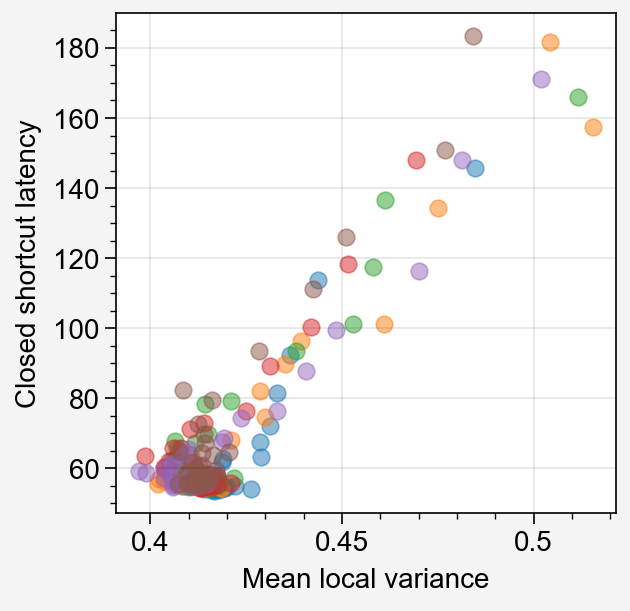

In [90]:
fig, ax = pplt.subplots()
probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]
for n, p in enumerate(probs):
    x = np.array(all_local_vars[p])
    x = x.mean(axis=2).mean(axis=0)
    y = np.array(summary[p]['ns_lens']).mean(axis=0)
    
    ax.scatter(x, y, color=rgb_colors[n], alpha=0.5)
    
    
ax.format(xlabel='Mean local variance', ylabel='Closed shortcut latency')


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


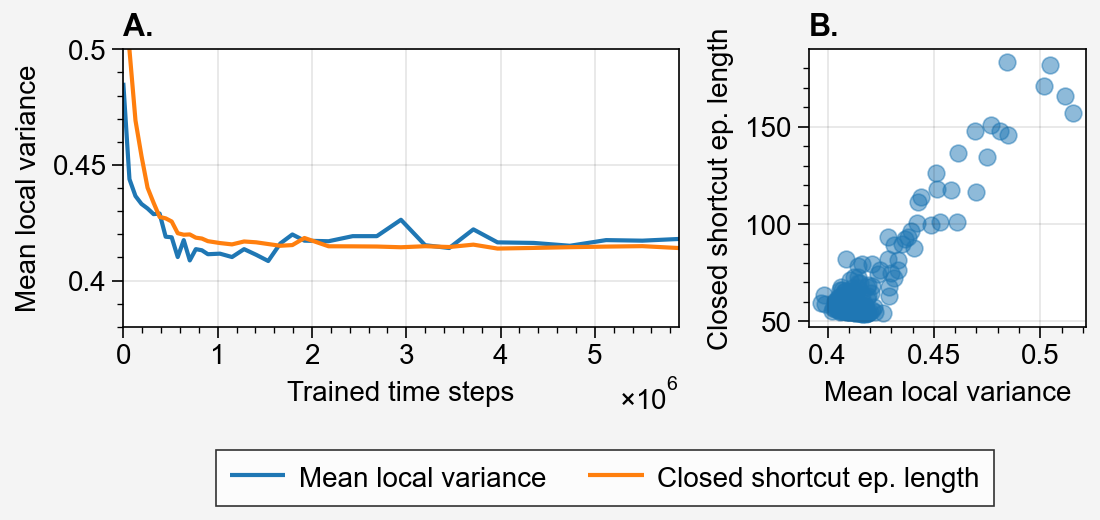

In [39]:
array = [1, 1, 2]

fig, ax = pplt.subplots(array, refaspect=2, figwidth=5.5, spanx=False, sharey=False)

lines = []
# probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]
probs = [0.1]

# A. Mean local variance and closed shortcut latency over time
for n, p in enumerate(probs):
    color = rgb_colors[0]
    
    y = np.array(all_local_vars[p])
    std = y.std(axis=0).mean(axis=1)
    mean = y.mean(axis=2).mean(axis=0)
    mins, maxs = mean-std, mean+std

    x = chk_sched*64*100
    # mean = mean * 700 - 236
    line = ax[0].plot(x, mean, color=color, label='Mean local variance')
    lines.append(line)
    
    y = np.array(summary[p]['ns_lens']).mean(axis=0)
    y = (y + 236) / 700
    lines.append(ax[0].plot(x, y, color=rgb_colors[1], label='Closed shortcut ep. length'))
    
# B. Mean local variance vs. closed shortcut latency
probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]
for n, p in enumerate(probs):
    x = np.array(all_local_vars[p])
    x = x.mean(axis=2).mean(axis=0)
    y = np.array(summary[p]['ns_lens']).mean(axis=0)
    
    ax[1].scatter(x, y, color=rgb_colors[0], alpha=0.5)

ax.format(abc='A.')
fig.legend(lines, loc='b')
ax[0].format(xlabel='Trained time steps', ylabel='Mean local variance', ylim=[0.38, 0.5])
# ax[0].format(xlabel='Trained time steps', ylabel='Closed shortcut latency', ylim=[40, 100])

ax[1].format(xlabel='Mean local variance', ylabel='Closed shortcut ep. length')

fig.savefig(save/'3_1_3_mean_local_variance_training')

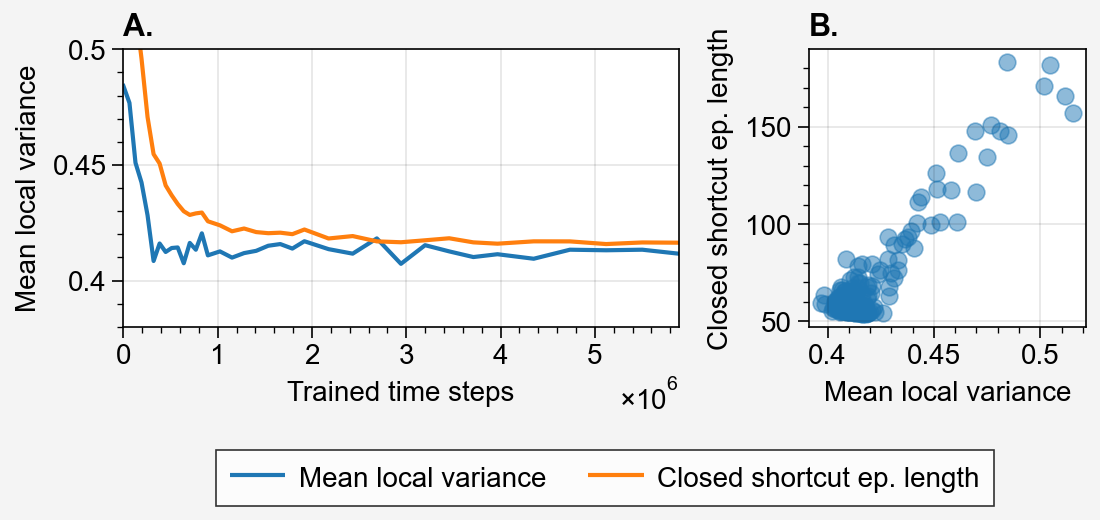

In [45]:
array = [1, 1, 2]

fig, ax = pplt.subplots(array, refaspect=2, figwidth=5.5, spanx=False, sharey=False)

lines = []
# probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]
probs = [0.8]

# A. Mean local variance and closed shortcut latency over time
for n, p in enumerate(probs):
    color = rgb_colors[0]
    
    y = np.array(all_local_vars[p])
    std = y.std(axis=0).mean(axis=1)
    mean = y.mean(axis=2).mean(axis=0)
    mins, maxs = mean-std, mean+std

    x = chk_sched*64*100
    # mean = mean * 700 - 236
    line = ax[0].plot(x, mean, color=color, label='Mean local variance')
    lines.append(line)
    
    y = np.array(summary[p]['ns_lens']).mean(axis=0)
    y = (y + 236) / 700
    lines.append(ax[0].plot(x, y, color=rgb_colors[1], label='Closed shortcut ep. length'))
    
# B. Mean local variance vs. closed shortcut latency
probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]
for n, p in enumerate(probs):
    x = np.array(all_local_vars[p])
    x = x.mean(axis=2).mean(axis=0)
    y = np.array(summary[p]['ns_lens']).mean(axis=0)
    
    ax[1].scatter(x, y, color=rgb_colors[0], alpha=0.5)

ax.format(abc='A.')
fig.legend(lines, loc='b')
ax[0].format(xlabel='Trained time steps', ylabel='Mean local variance', ylim=[0.38, 0.5])
# ax[0].format(xlabel='Trained time steps', ylabel='Closed shortcut latency', ylim=[40, 100])

ax[1].format(xlabel='Mean local variance', ylabel='Closed shortcut ep. length')

# fig.savefig(save/'3_1_3_mean_local_variance_training')

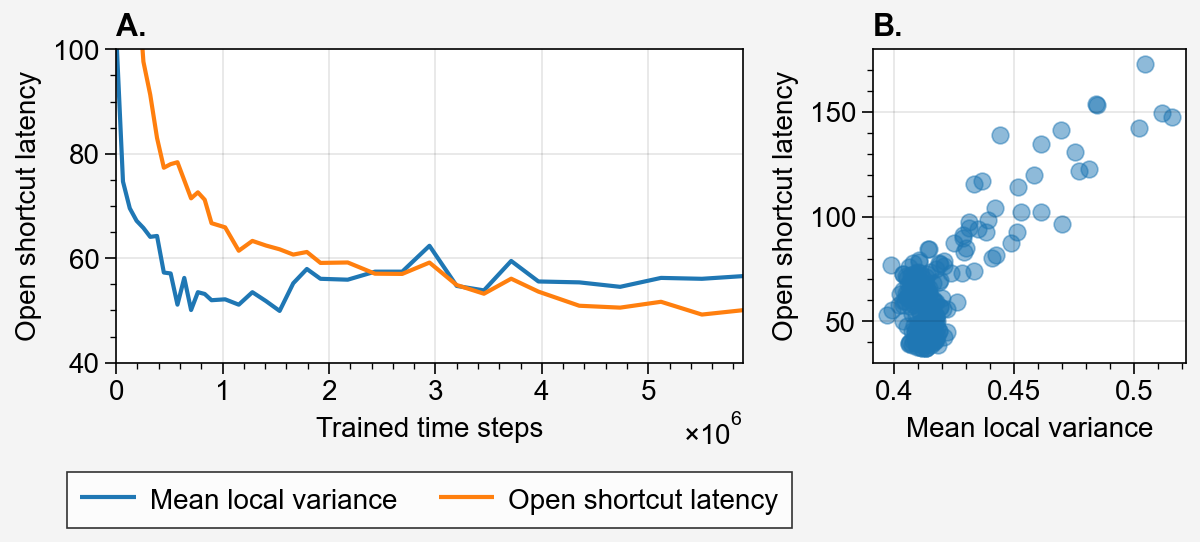

In [133]:
array = [1, 1, 2]

fig, ax = pplt.subplots(array, refaspect=2, figwidth=6, spanx=False, sharey=False)

lines = []
# probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]
probs = [0.1]

# A. Mean local variance and closed shortcut latency over time
for n, p in enumerate(probs):
    color = rgb_colors[0]
    
    y = np.array(all_local_vars[p])
    std = y.std(axis=0).mean(axis=1)
    mean = y.mean(axis=2).mean(axis=0)
    mins, maxs = mean-std, mean+std

    x = chk_sched*64*100
    mean = mean * 700 - 236
    line = ax[0].plot(x, mean, color=color, label='Mean local variance')
    lines.append(line)
    
    y = np.array(summary[p]['ws_lens']).mean(axis=0)
    # y = (y + 236) / 700
    lines.append(ax[0].plot(x, y, color=rgb_colors[1], label='Open shortcut latency'))
    
# B. Mean local variance vs. closed shortcut latency
probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]
for n, p in enumerate(probs):
    x = np.array(all_local_vars[p])
    x = x.mean(axis=2).mean(axis=0)
    y = np.array(summary[p]['ws_lens']).mean(axis=0)
    
    ax[1].scatter(x, y, color=rgb_colors[0], alpha=0.5)

ax.format(abc='A.')
ax[0].legend(lines, loc='b')
# ax[0].format(xlabel='Trained time steps', ylabel='Mean local variance', ylim=[0.38, 0.5])
ax[0].format(xlabel='Trained time steps', ylabel='Open shortcut latency', ylim=[40, 100])

ax[1].format(xlabel='Mean local variance', ylabel='Open shortcut latency')

## K-Means spatial heatmap clustering

### Cluster centers picture

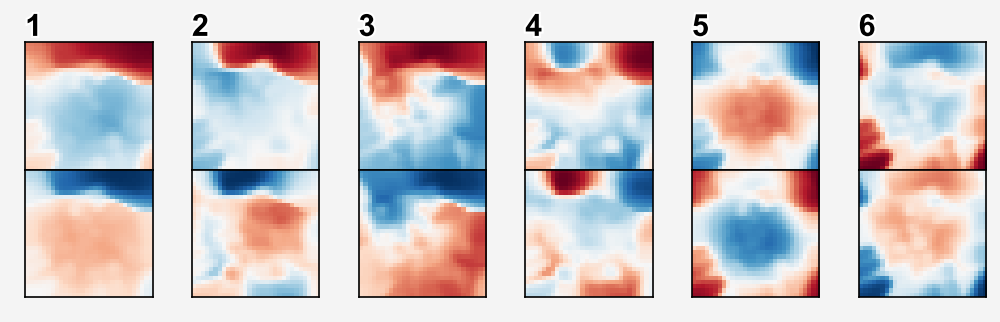

In [47]:
pairs = get_best_negative_cluster_pairs(k.cluster_centers_, k_pair_targets)
centers = k.cluster_centers_
centers = centers.reshape(-1, 30, 30)

abcs = ['1', '2', '3', '4', '5', '6']
fig, ax = pplt.subplots(nrows=2, ncols=len(pairs), hspace=0, figwidth=5)
title = []
for i, pair in enumerate(pairs):
    ax[0, i].imshow(centers[pair[0]])
    ax[1, i].imshow(centers[pair[1]])
    
    # title.append(str(i+1))
    
    add_abc_to_subaxes(ax[0, i], text=abcs[i])

ax.format(xticks=[], yticks=[])
fig.savefig(save/'3_2_1_spatial_cluster_centers')


### Cluster pair frequencies

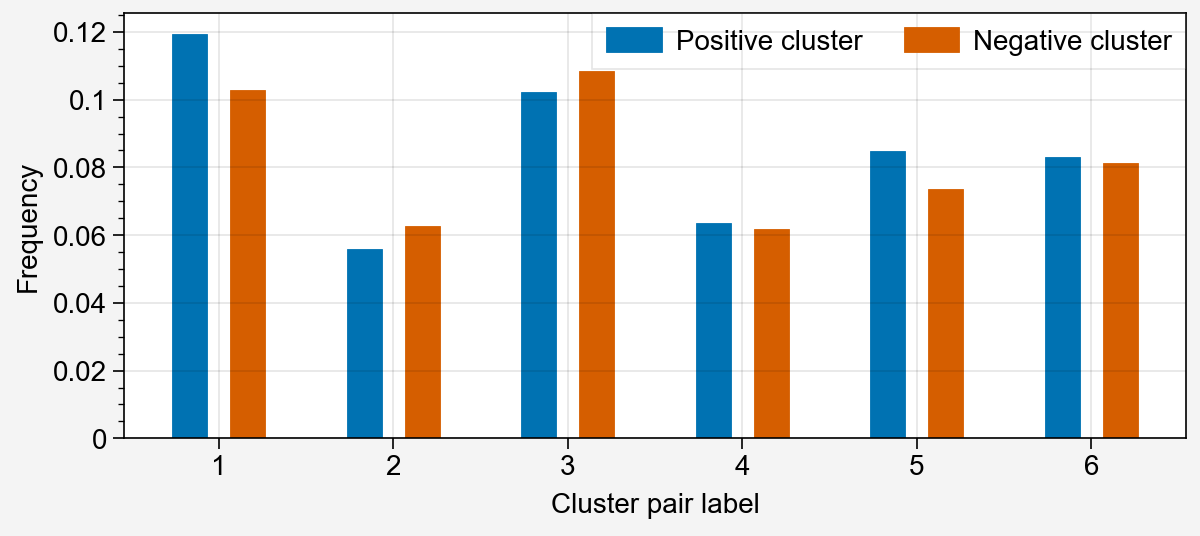

In [157]:
all_hms = pickle.load(open(folder/'spatial_hms', 'rb'))
stacked_hms = []
probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]
for p in probs:
    stacked_hms.append(all_hms[p].reshape(-1, 900))
stacked_hms = np.vstack(stacked_hms)

labels = k.predict(stacked_hms)
pairs = get_best_negative_cluster_pairs(k.cluster_centers_, k_pair_targets)
total = stacked_hms.shape[0]
pos_labels, neg_labels = kmean_label_pair_mapping(pairs, labels)
pos_counts, neg_counts = count_kmean_freqs(pos_labels, 6), count_kmean_freqs(neg_labels, 6)

fig, ax = pplt.subplots(refaspect=2.5, figwidth=6)
ax.bar(np.arange(1, 1+3*6, 3), pos_counts/total, width=0.2, label='Positive cluster')
ax.bar(np.arange(2, 2+3*6, 3), neg_counts/total, width=0.2, label='Negative cluster')
ax.format(xlabel='Cluster pair label', ylabel='Frequency',
          xlocator=np.arange(1.5, 1.5+3*8, 3), xformatter=[str(i) for i in range(1, 9)])
ax.legend(alpha=0.1)

### Cluster frequencies across training

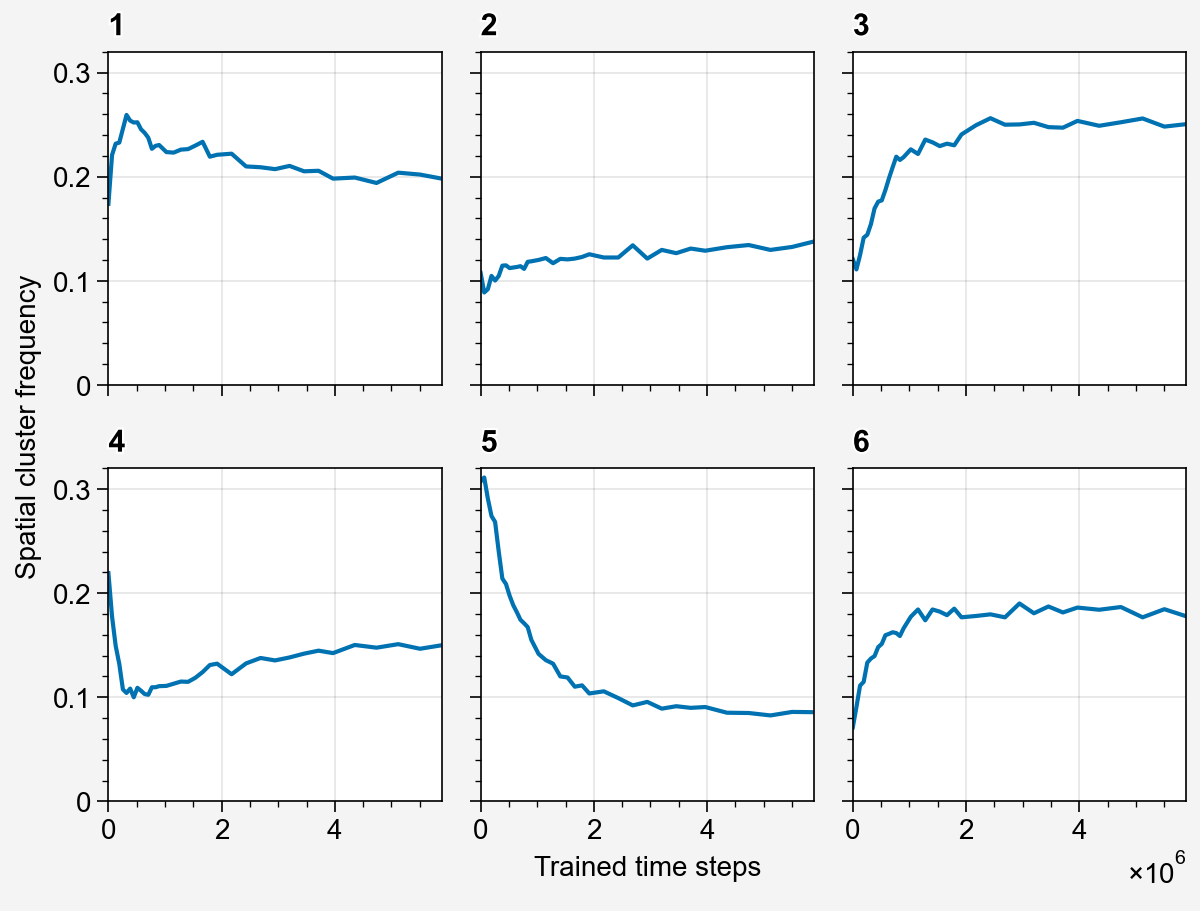

In [ ]:
stacked_hms = []
probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]

fig, ax = pplt.subplots(nrows=2, ncols=3, figwidth=6)

lines = []
comb_counts = np.zeros((6, 10, 36, 6))
for j, p in enumerate(probs):
    hms = all_hms[p]
    for t in trials:
        for chk in range(36):
            counts = hm_count_kmean_freqs(hms[t, chk], k, True, targets=k_pair_targets)
            comb_counts[j, t, chk] = counts

mean_counts = comb_counts.mean(axis=0).mean(axis=0)
abcs = ['1', '2', '3', '4', '5', '6']
for i in range(6):
    x = chk_sched*64*100
    if i not in [2, 5]:
        x = x/1e6
    line = ax[i].plot(x, mean_counts[:, i] / 64)
    if i == 0:
        lines.append(line)
        
    add_abc_to_subaxes(ax[i], text=abcs[i])


ax.format(xlabel='Trained time steps', ylabel='Spatial cluster frequency', ylim=[0, 0.32])
    

### Clusters and their mean local variances

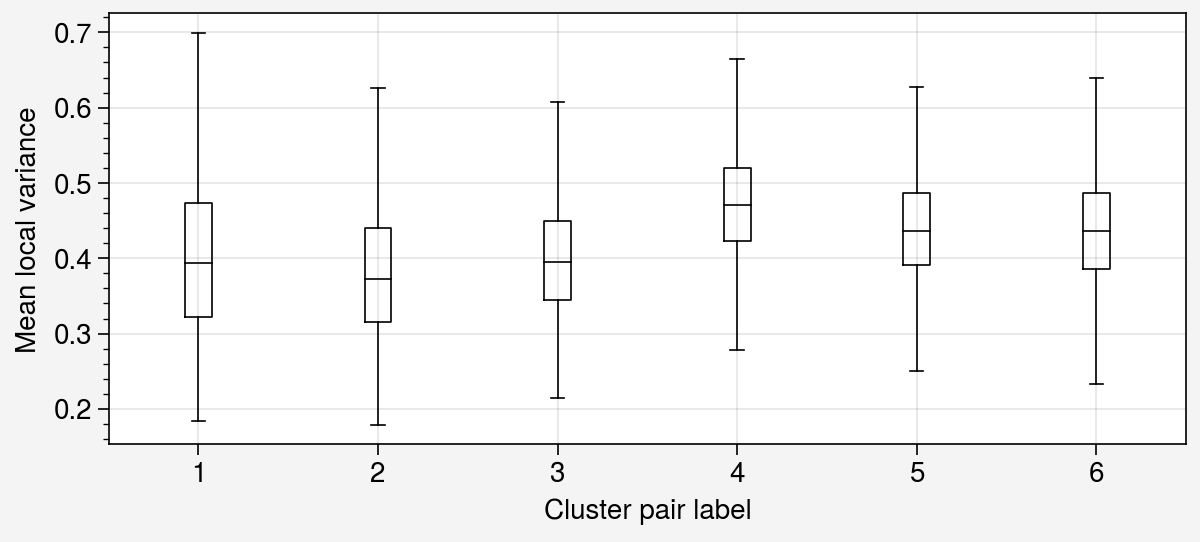

In [46]:
stacked_hms = []
stacked_vars = []
probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]
for p in probs:
    stacked_hms.append(all_hms[p].reshape(-1, 900))
    stacked_vars.append(all_local_vars[p].reshape(-1))
stacked_hms = np.vstack(stacked_hms)
stacked_vars = np.concatenate(stacked_vars)

labels = k.predict(stacked_hms)
pairs = get_best_negative_cluster_pairs(k.cluster_centers_, targets)
labels = np.array(kmean_label_pair_mapping(pairs, labels, True))

fig, ax = pplt.subplots(refaspect=2.5, figwidth=6)

for i in range(6):
    ax.boxplot([i], stacked_vars[labels == i], showfliers=False)
    
ax.format(xlabel='Cluster pair label', xlocator=range(6), xformatter=[str(i) for i in range(1, 7)],
          ylabel='Mean local variance')

### Combined k-means plot

meta NOT subset; don't know how to subset; dropped


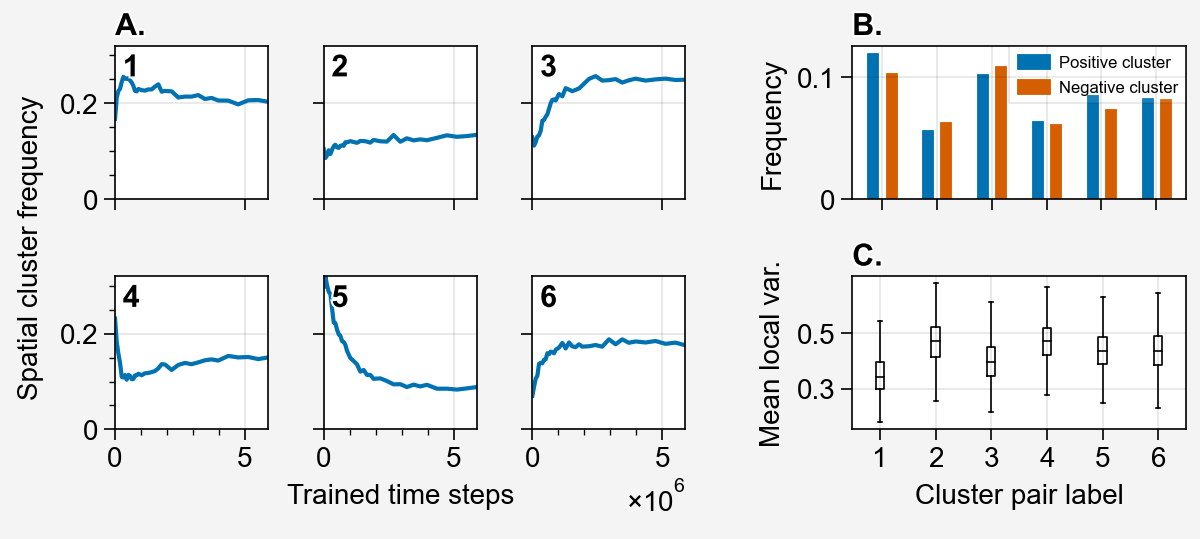

In [93]:
all_hms = pickle.load(open(folder/'spatial_hms', 'rb'))

array = [
  [1, 2, 3, 7, 7],
  [4, 5, 6, 8, 8]
]
fig, ax = pplt.subplots(array, wspace=(2, 2, 6, 1), figwidth=6, sharey=False, sharex=False)


# Positive and Negative cluster frequencies
stacked_hms = []
probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]
for p in probs:
    stacked_hms.append(all_hms[p].reshape(-1, 900))
stacked_hms = np.vstack(stacked_hms)

labels = k.predict(stacked_hms)
pairs = get_best_negative_cluster_pairs(k.cluster_centers_, k_pair_targets)
total = stacked_hms.shape[0]
pos_labels, neg_labels = kmean_label_pair_mapping(pairs, labels)
pos_counts, neg_counts = count_kmean_freqs(pos_labels, 6), count_kmean_freqs(neg_labels, 6)

ax[6].bar(np.arange(1, 1+3*6, 3), pos_counts/total, width=0.2, label='Positive cluster')
ax[6].bar(np.arange(2, 2+3*6, 3), neg_counts/total, width=0.2, label='Negative cluster')
ax[6].format(ylabel='Frequency',
          xlocator=np.arange(1.5, 1.5+3*8, 3),# xformatter=[str(i) for i in range(1, 9)])
          xformatter=['']*8, ylocator=[0, 0.1], yformatter=['0', '0.1'])
ax[6].legend(loc='ur', alpha=0.1, ncols=1, fontsize=6)


# Cluster mean local variances
stacked_hms = []
stacked_vars = []
probs = [0.1, 0.2, 0.3, 0.4, 0.8]
for p in probs:
    stacked_hms.append(all_hms[p].reshape(-1, 900))
    stacked_vars.append(all_local_vars[p].reshape(-1))
stacked_hms = np.vstack(stacked_hms)
stacked_vars = np.concatenate(stacked_vars)

labels = k.predict(stacked_hms)
pairs = get_best_negative_cluster_pairs(k.cluster_centers_, k_pair_targets)
labels = np.array(kmean_label_pair_mapping(pairs, labels, True))

for i in range(6):
    ax[7].boxplot([i], stacked_vars[labels == i], showfliers=False)
ax[7].format(xlabel='Cluster pair label', xlocator=range(6), xformatter=[str(i) for i in range(1, 7)],
          ylabel='Mean local var.', ylocator=[0.3, 0.5], yformatter=['0.3', '0.5'])


# Cluster frequencies through training
stacked_hms = []
probs = [0.1, 0.2, 0.3, 0.5, 0.8]

lines = []
comb_counts = np.zeros((5, 10, 36, 6))
for j, p in enumerate(probs):
    hms = all_hms[p]
    for t in trials:
        for chk in range(36):
            counts = hm_count_kmean_freqs(hms[t, chk], k, True, targets=k_pair_targets)
            comb_counts[j, t, chk] = counts

mean_counts = comb_counts.mean(axis=0).mean(axis=0)
abcs = ['1', '2', '3', '4', '5', '6']
for i in range(6):
    x = chk_sched*64*100
    if i not in [2, 5]:
        x = x/1e6
    line = ax[i].plot(x, mean_counts[:, i] / 64)
    if i == 0:
        lines.append(line)
    add_abc_to_subaxes(ax[i], text=abcs[i], top=0.8, left=0.05)
    
ax[:6].format(ylim=[0, 0.32])
ax[:2].format(xlocator=[0, 5], xformatter=['', ''])
ax[2].format(xlocator=[0, 5e6], xformatter=['', ''])
ax[1:3].format(ylocator=[0, 0.2], yformatter=['', ''])
ax[4:6].format(ylocator=[0, 0.2], yformatter=['', ''])
ax[4].format(xlabel='Trained time steps')
fig.text(0.026, 0.54, 'Spatial cluster frequency', va='center', ha='center', rotation=90)


add_abc_to_subaxes(ax[0], 'A.', top=1.07)
add_abc_to_subaxes(ax[6], 'B.', top=1.07)
add_abc_to_subaxes(ax[7], 'C.', top=1.07)

fig.savefig(save/'3_2_5_kmeans_comb_plot')

## Shortcut sensitivity measure

### Example heatmaps

In [94]:
folder = Path('data/shortcut/wc1.5_policy')
wsns_hms = pickle.load(open(folder/'wsns_hms', 'rb'))

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


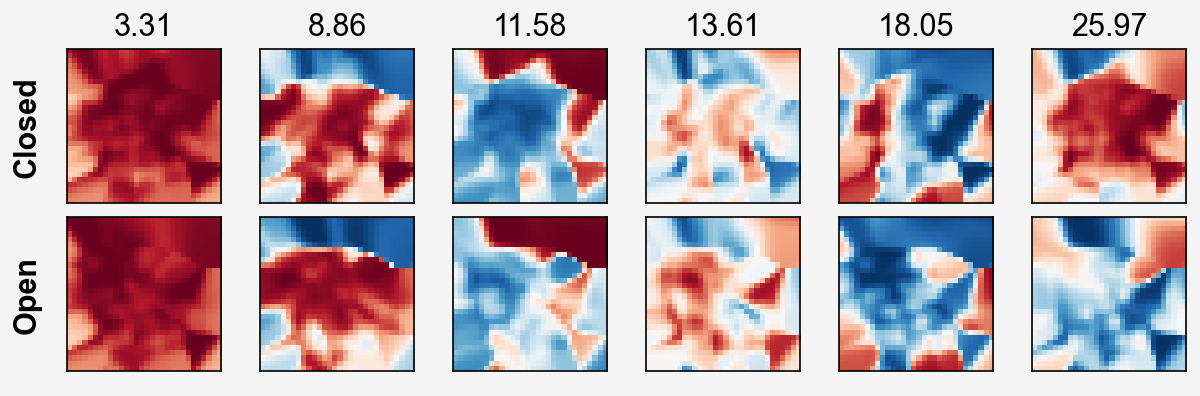

In [96]:
p = 0.5
t = 3
chk = 30
ns_hm = wsns_hms['ns_hms'][p][t, chk]
ws_hm = wsns_hms['ws_hms'][p][t, chk]
dist = np.sqrt(((ns_hm.reshape(64, 900) - ws_hm.reshape(64, 900))**2).sum(axis=1))

idxs = np.argsort(dist)

fig, ax = pplt.subplots(nrows=2, ncols=6, hspace=0.5, figwidth=6)

title = []
for i, n in enumerate(np.arange(0, 64, 12)):
    idx = idxs[n]
    ax[0, i].imshow(ns_hm[idx], vmin=-1, vmax=1)
    ax[1, i].imshow(ws_hm[idx], vmin=-1, vmax=1)
    title.append(f'{dist[idx]:.2f}')
title += ['']*6

ax.format(xticks=[], yticks=[], leftlabels=['Closed', 'Open'], title=title)
fig.savefig(save/'3_3_1_example_landmark_sensitive_hms')

### Shortcut sensitivty across training

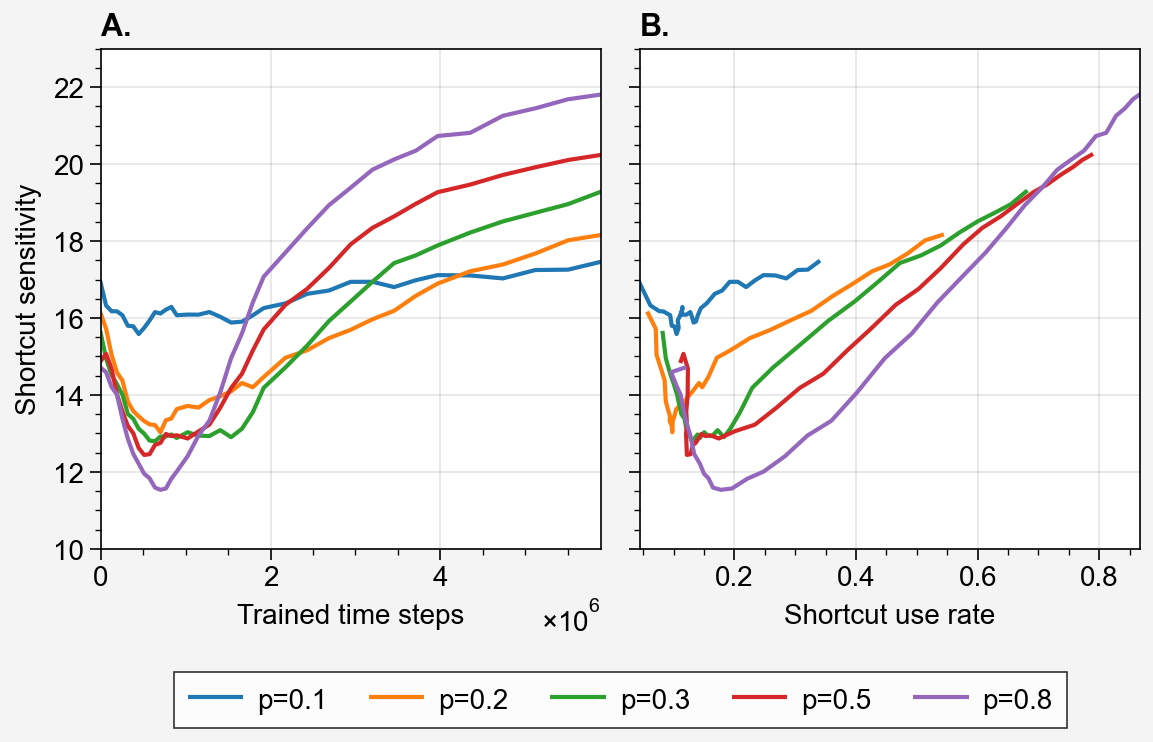

In [86]:
fig, ax = pplt.subplots(ncols=2, sharex=False)

lines = []
# Shortcut sensitivity across training timesteps
for i, p in enumerate(probs):
    dists = all_wsnshm_dist[p]
    dists = pd.Series(dists.mean(axis=2).mean(axis=0))
    dists = dists.ewm(alpha=0.3).mean()
    lines.append(ax[0].plot(chk_sched*64*100, dists, label=f'p={p}', color=rgb_colors[i]))
    
# Shortcut sensitivity across shortcut use rate    
for i, p in enumerate(probs):
    dists = all_wsnshm_dist[p]
    dists = pd.Series(dists.mean(axis=2).mean(axis=0))
    dists = dists.ewm(alpha=0.3).mean()
    surs = summary[p]['surs']
    surs = np.array(surs).mean(axis=0)
    surs = pd.Series(surs).ewm(alpha=0.1).mean()
    
    ax[1].plot(surs, dists, label=f'p={p}', color=rgb_colors[i])


ax.format(ylabel='Shortcut sensitivity', ylim=[10, 23], abc='A.')
ax[0].format(xlabel='Trained time steps')
ax[1].format(xlabel='Shortcut use rate')
fig.legend(lines, loc='b', ncols=6)

### Shortcut sensitivity and shortcut use on the same plot

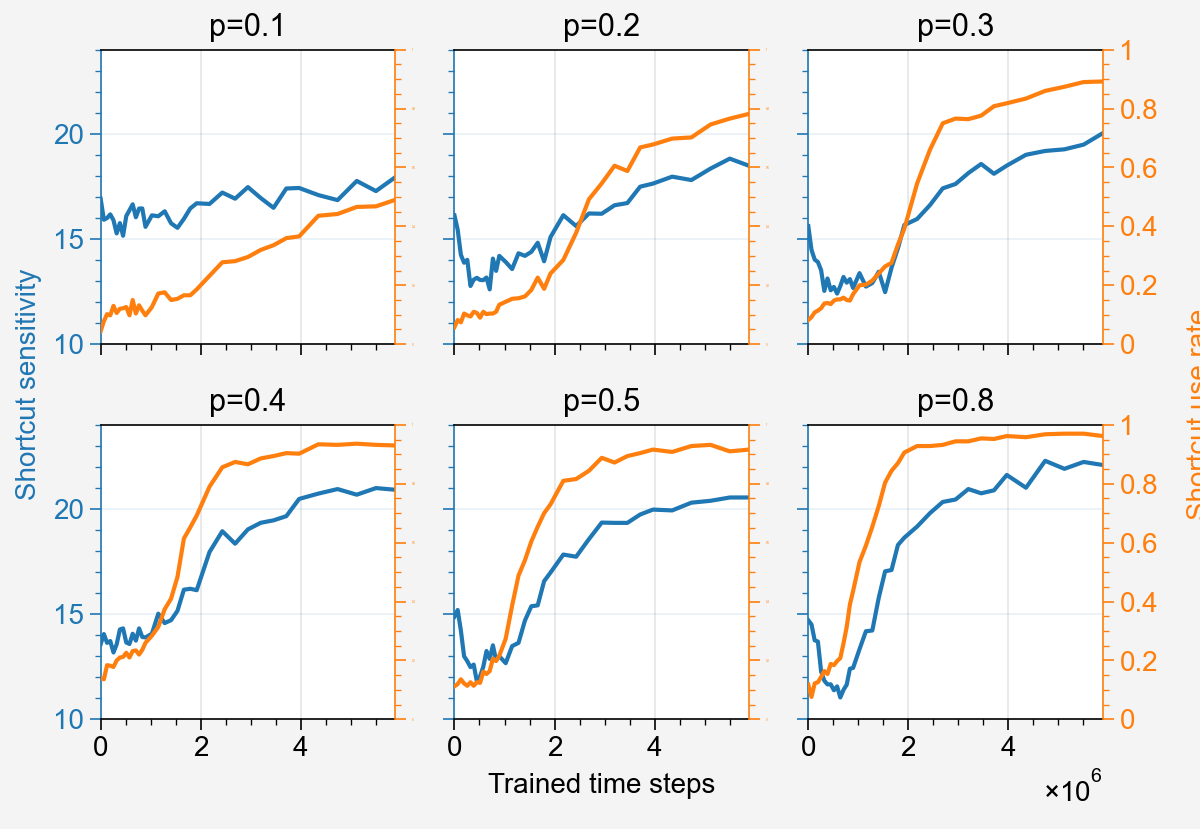

In [10]:
probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]
fig, ax = pplt.subplots(nrows=2, ncols=3, figwidth=6)
sax = ax.dualy(lambda x: (x-10) / 14)

for i, p in enumerate(probs):
    x = chk_sched * 64 * 100
    if i in [0, 1, 3, 4]:
        x = x / 1000000
    y0 = all_wsnshm_dist[p].mean(axis=2).mean(axis=0)
    y1 = np.mean(summary[p]['surs'], axis=0)

    ax[i].plot(x, y0, c=rgb_colors[0], label='Shortcut Sensitivity')
    sax[i].plot(x, y1, c=rgb_colors[1])

ax.format(ylabel='Shortcut sensitivity', ylabelcolor=rgb_colors[0],
          ytickcolor=rgb_colors[0], yticklabelcolor=rgb_colors[0], ygridcolor=rgb_colors[0],
          xlabel='Trained time steps',
          ylim=[10, 24], title=[f'p={p}' for p in probs])
sax.format(ylabelcolor=rgb_colors[1],
          ytickcolor=rgb_colors[1], yticklabelcolor=rgb_colors[1], ygridcolor=rgb_colors[1])

for a in ax:
    a.spines['left'].set_color(rgb_colors[0])
for a in sax:
    a.spines['right'].set_color(rgb_colors[1])

fig.text(1, 0.5, 'Shortcut use rate', rotation=90, 
         transform=fig.transFigure, ha='center',
         va='center', color=rgb_colors[1]
)
sax[:, :2].format(fontsize=0)


### Combined individual p values and combined plots

meta NOT subset; don't know how to subset; dropped


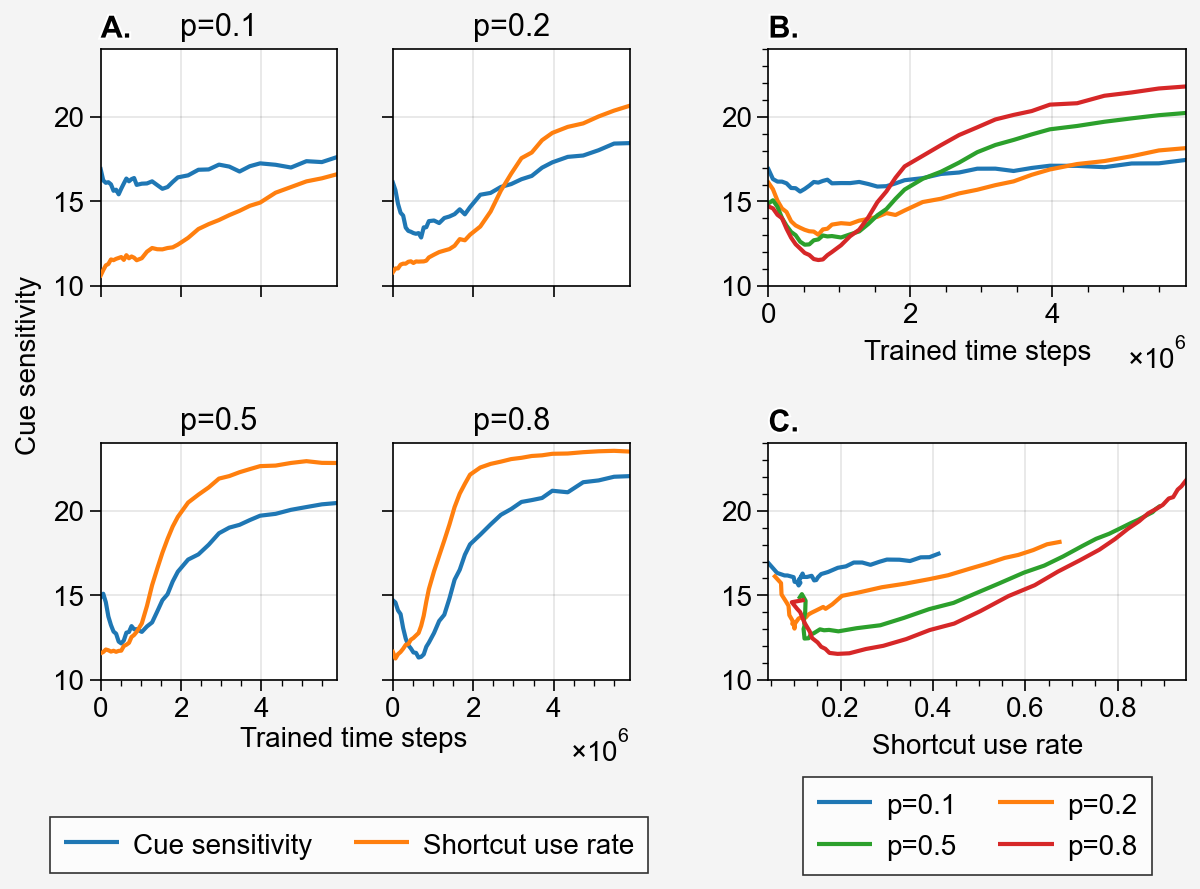

In [176]:
probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]

array = [
    [1, 2, 5, 5],
    [3, 4, 6, 6]
]

fig, ax = pplt.subplots(array, figwidth=6, wspace=(2, 5, -2), sharey=False, spany=True, sharex=False)
sax = ax[:4].dualy(lambda x: (x-10) / 14)

# Individual p value plots
probs2 = [0.1, 0.2, 0.5, 0.8]
for i, p in enumerate(probs2):
    lines = []
    
    x = chk_sched * 64 * 100
    if i in [0, 2]:
        x = x / 1000000
    y0 = all_wsnshm_dist[p].mean(axis=2).mean(axis=0)
    y1 = np.mean(summary[p]['surs'], axis=0)
    
    y0 = pd.Series(y0).ewm(alpha=0.5).mean()
    y1 = pd.Series(y1).ewm(alpha=0.5).mean()

    lines.append(ax[i].plot(x, y0, c=rgb_colors[0], label='Cue sensitivity'))
    lines.append(sax[i].plot(x, y1, c=rgb_colors[1], label='Shortcut use rate'))

ax.format(ylim=[10, 24])
ax[:4].format(#ylabelcolor=rgb_colors[0], ytickcolor=rgb_colors[0], yticklabelcolor=rgb_colors[0], ygridcolor=rgb_colors[0],
          title=[f'p={p}' for p in probs2],
          ylocator=[10, 15, 20], yformatter=['', '', ''])
ax[0].format(ylabel='Cue sensitivity', yformatter=['10', '15', '20'])
ax[2].format(ylabel='Cue sensitivity', yformatter=['10', '15', '20'])
ax[0].format(xlocator=[0, 2, 4], xformatter=['', '', ''])
ax[1].format(xlocator=[0, 2e6, 4e6], xformatter=['', '', ''])
ax[2].format(xlocator=[0, 2, 4])
ax[3].format(xlocator=[0, 2e6, 4e6])
sax.format(yticks=[])
fig.text(0.2, 0.16, 'Trained time steps')
ax[2].legend(lines, loc='b', bbox_to_anchor=(0.4, 0, 1.3, 0))
# sax.format(ylabelcolor=rgb_colors[1],
#           ytickcolor=rgb_colors[1], yticklabelcolor=rgb_colors[1], ygridcolor=rgb_colors[1])
# sax[1].format(ylabel='Shortcut use rate')

# for a in ax[:4]:
#     a.spines['left'].set_color(rgb_colors[0])
# for a in sax:
#     a.spines['right'].set_color(rgb_colors[1])

# fig.text(1, 0.5, 'Shortcut use rate', rotation=90, 
#          transform=fig.transFigure, ha='center',
#          va='center', color=rgb_colors[1]
# )
# sax[:, :2].format(fontsize=0)




# Combined results
lines = []
# Shortcut sensitivity across training timesteps
for i, p in enumerate(probs2):
    dists = all_wsnshm_dist[p]
    dists = pd.Series(dists.mean(axis=2).mean(axis=0))
    dists = dists.ewm(alpha=0.3).mean()
    lines.append(ax[4].plot(chk_sched*64*100, dists, label=f'p={p}', color=rgb_colors[i]))
    
# Shortcut sensitivity across shortcut use rate    
for i, p in enumerate(probs2):
    dists = all_wsnshm_dist[p]
    dists = pd.Series(dists.mean(axis=2).mean(axis=0))
    dists = dists.ewm(alpha=0.3).mean()
    surs = summary[p]['surs']
    surs = np.array(surs).mean(axis=0)
    surs = pd.Series(surs).ewm(alpha=0.2).mean()
    
    ax[5].plot(surs, dists, label=f'p={p}', color=rgb_colors[i])


ax[4].format(xlabel='Trained time steps')
ax[5].format(xlabel='Shortcut use rate')
ax[5].legend(lines, loc='b', ncols=2)


add_abc_to_subaxes(ax[0], 'A.')
add_abc_to_subaxes(ax[4], 'B.')
add_abc_to_subaxes(ax[5], 'C.')

fig.savefig(save/'3_3_4_cue_sensitivity_combined')

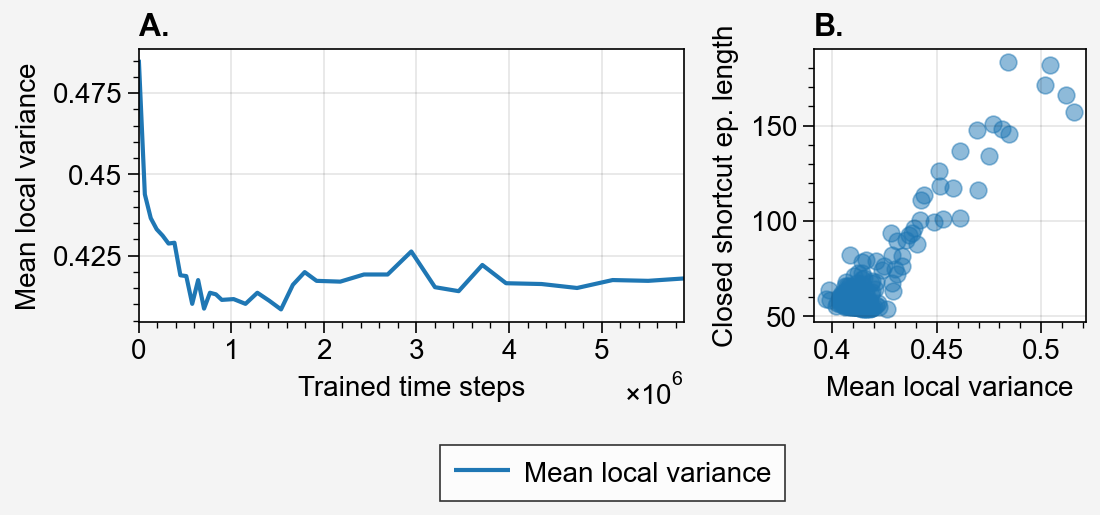

In [186]:
array = [1, 1, 2]

fig, ax = pplt.subplots(array, refaspect=2, figwidth=5.5, spanx=False, sharey=False)

lines = []
# probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]
probs = [0.1]

# A. Mean local variance and closed shortcut latency over time
for n, p in enumerate(probs):
    color = rgb_colors[0]
    
    y = np.array(all_local_vars[p])
    std = y.std(axis=0).mean(axis=1)
    mean = y.mean(axis=2).mean(axis=0)
    mins, maxs = mean-std, mean+std
    
    x = chk_sched*64*100
    # mean = np.diff(mean)
    # x = x[1:]
    line = ax[0].plot(x, mean, color=color, label='Mean local variance')
    lines.append(line)
        
# B. Mean local variance vs. closed shortcut latency
probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]
for n, p in enumerate(probs):
    x = np.array(all_local_vars[p])
    x = x.mean(axis=2).mean(axis=0)
    y = np.array(summary[p]['ns_lens']).mean(axis=0)
    
    ax[1].scatter(x, y, color=rgb_colors[0], alpha=0.5)

ax.format(abc='A.')
fig.legend(lines, loc='b')
ax[0].format(xlabel='Trained time steps', ylabel='Mean local variance')
# ax[0].format(xlabel='Trained time steps', ylabel='Closed shortcut latency', ylim=[40, 100])

ax[1].format(xlabel='Mean local variance', ylabel='Closed shortcut ep. length')

# fig.savefig(save/'3_1_3_mean_local_variance_training')

### Shortcut sensitivity at defined time points

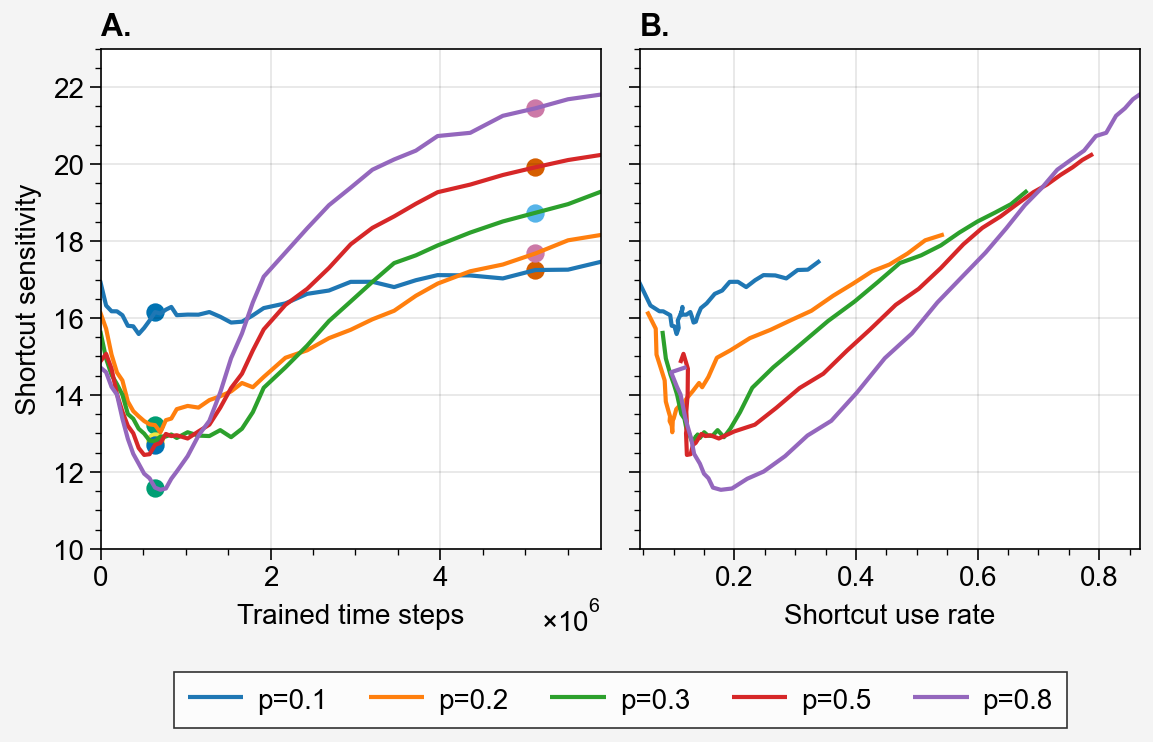

In [35]:
fig, ax = pplt.subplots(ncols=2, sharex=False)

target_chks = [10, 33]

lines = []
# Shortcut sensitivity across training timesteps
for i, p in enumerate(probs):
    dists = all_wsnshm_dist[p]
    dists = pd.Series(dists.mean(axis=2).mean(axis=0))
    dists = dists.ewm(alpha=0.3).mean()
    lines.append(ax[0].plot(chk_sched*64*100, dists, label=f'p={p}', color=rgb_colors[i]))
    for chk in target_chks:
        ax[0].scatter(chk_sched[chk]*64*100, dists[chk])
    
# Shortcut sensitivity across shortcut use rate    
for i, p in enumerate(probs):
    dists = all_wsnshm_dist[p]
    dists = pd.Series(dists.mean(axis=2).mean(axis=0))
    dists = dists.ewm(alpha=0.3).mean()
    surs = summary[p]['surs']
    surs = np.array(surs).mean(axis=0)
    surs = pd.Series(surs).ewm(alpha=0.1).mean()
    
    ax[1].plot(surs, dists, label=f'p={p}', color=rgb_colors[i])


ax.format(ylabel='Shortcut sensitivity', ylim=[10, 23], abc='A.')
ax[0].format(xlabel='Trained time steps')
ax[1].format(xlabel='Shortcut use rate')
fig.legend(lines, loc='b', ncols=6)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


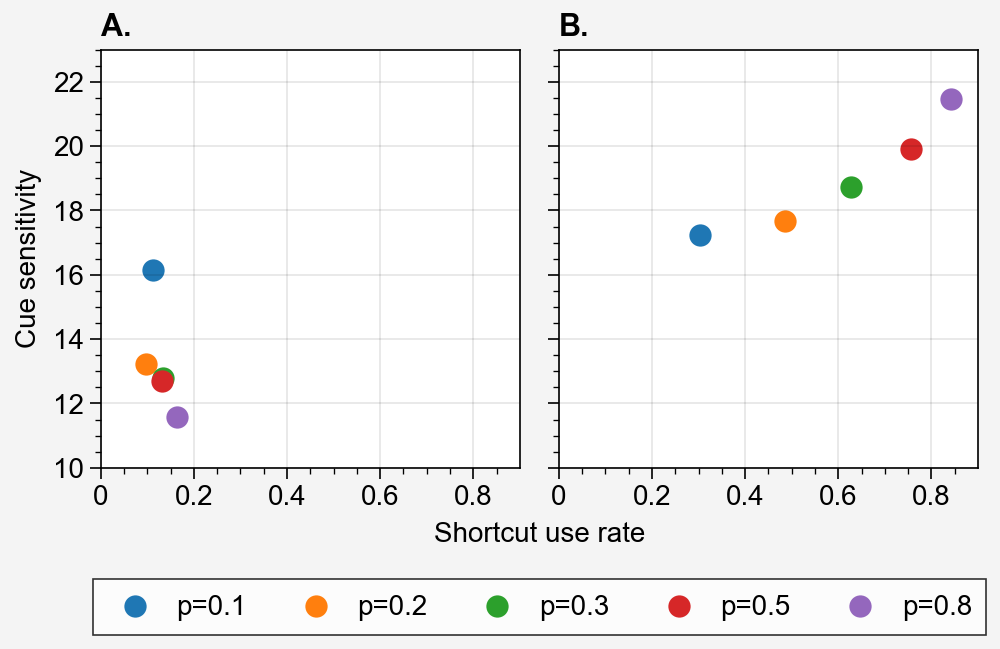

In [47]:
fig, ax = pplt.subplots(ncols=2, sharex=True, figwidth=5)

target_chks = [10, 33]

lines = []
# Shortcut sensitivity across training timesteps
for i, p in enumerate(probs):
    dists = all_wsnshm_dist[p]
    dists = pd.Series(dists.mean(axis=2).mean(axis=0))
    dists = dists.ewm(alpha=0.3).mean()

    surs = summary[p]['surs']
    surs = np.array(surs).mean(axis=0)
    surs = pd.Series(surs).ewm(alpha=0.1).mean()
    
    for j, chk in enumerate(target_chks):
        s = ax[j].scatter(surs[chk], dists[chk], label=f'p={p}', c=rgb_colors[i], s=55)
        if j == 0:
            lines.append(s)
    


ax.format(ylabel='Cue sensitivity', ylim=[10, 23], abc='A.',
         xlim=[0, 0.9], xlabel='Shortcut use rate')
fig.legend(lines, loc='b', ncols=6)

fig.savefig(save/'3_3_5_cue_sensitivity_at_set_points')

# Population representations

## K-means clustering

Plots to show how clustering looks for one agent and their trajectories, but should be supplemental

In [36]:
folder = Path('data/shortcut/wc1.5_policy')
wsns_res = pickle.load(open(folder/'0.5_5', 'rb'))

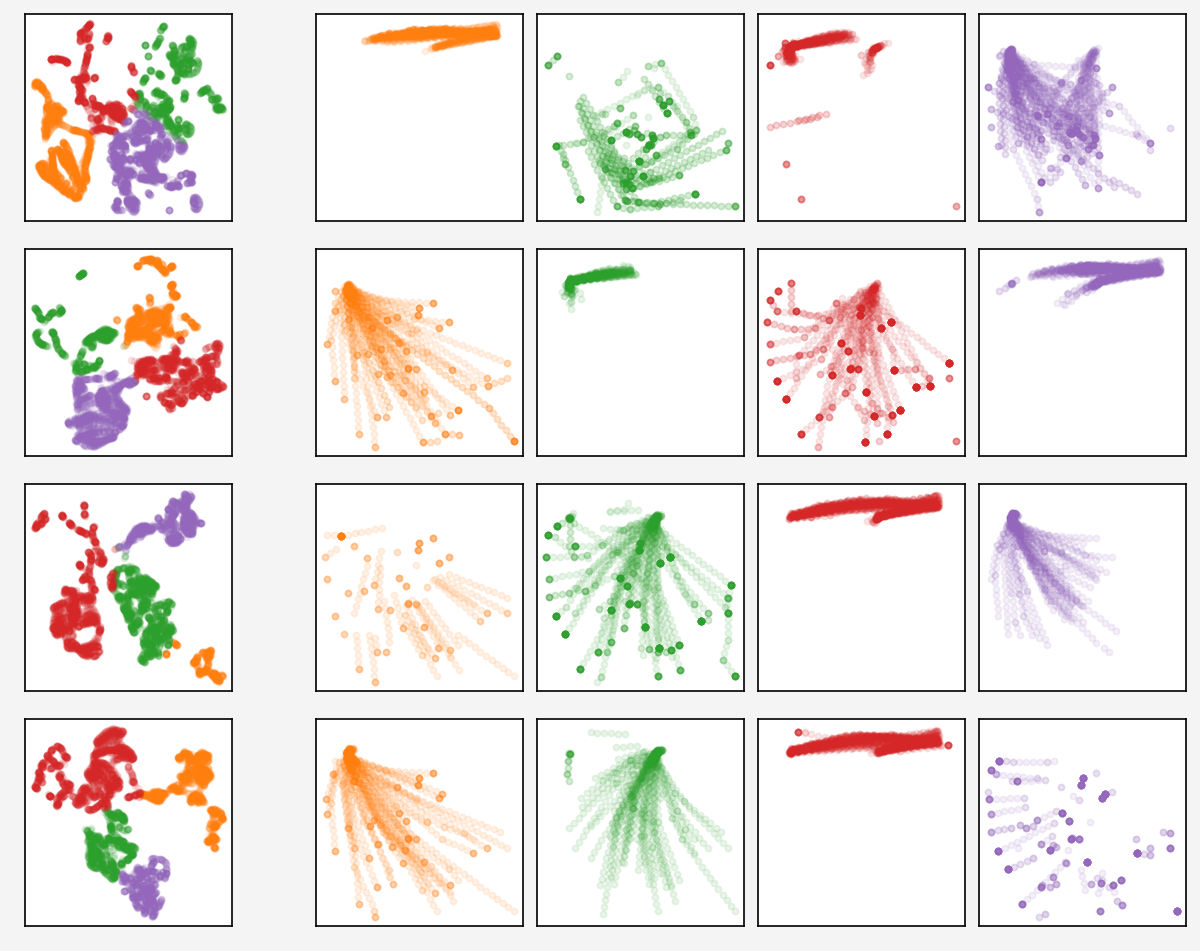

In [71]:
fig, ax = pplt.subplots(nrows=4, ncols=5, sharex=False, sharey=False, hspace=1, 
                        figwidth=6, wspace=(3, 0.5, 0.5, 0.5))
for i, chk in enumerate([15, 20, 25, 30]):
    res = combine_wsns(wsns_res, chk=chk)
    activ2d = res['activ2d']
    pos = res['pos']

    k = KMeans(n_clusters=4)
    labels = k.fit_predict(res['activ2d'])
    
    colored_activ2d_plot(activ2d,  labels, pos, split_activ=False, ax=ax[i, :])
    
ax.format(xticks=[], yticks=[])

## Trajectory based clustering

The actual method we used, inspired by K-Means, is to assign data points based on what part of the trajectory they were and check what the cluster activations look like as a result

In [3]:
folder = Path('data/shortcut/wc1.5_policy')
wsns_res = pickle.load(open(folder/'0.8_2', 'rb'))

meta NOT subset; don't know how to subset; dropped


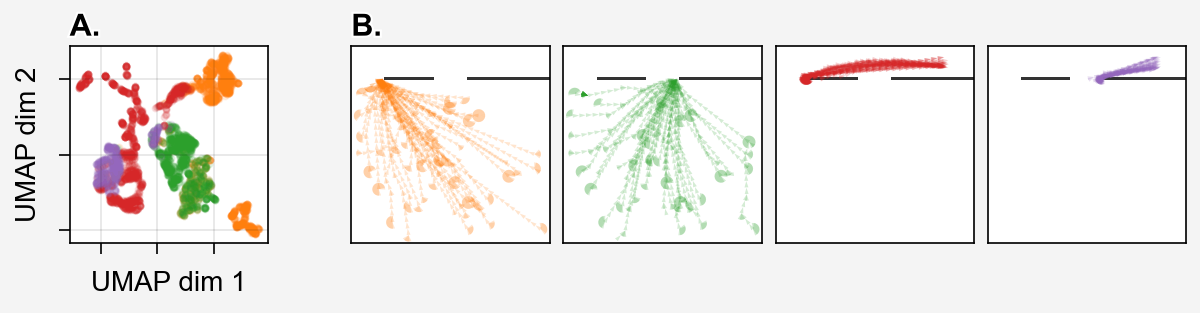

In [14]:
fig, ax = pplt.subplots(ncols=5, sharey=False, wspace=(3, 0.5, 0.5, 0.5), figwidth=6)

res = combine_wsns(wsns_res, chk=25)
activ2d = res['activ2d']
pos = res['pos']
ep_pos = res['ep_pos']
used = res['used']
angle = res['angle'].squeeze()
labels, _ = decompose_shortcut_trajectories(ep_pos=ep_pos, ep_shortcut_used=used)
    
colored_activ2d_plot(activ2d, labels, pos, split_activ=False, ax=ax, angle=angle)

ax.format(xticks=[], yticks=[])

add_abc_to_subaxes(ax[0], 'A.')
add_abc_to_subaxes(ax[1], 'B.')

ax[0].format(xlabel='UMAP dim 1', ylabel='UMAP dim 2', xlocator=[-10, 0, 10], ylocator=[-5, 5, 15],
            xformatter=['', '', ''], yformatter=['', '', ''])
fig.savefig(save/'4_2_trajectory_clustering_example')

### Green orange separation across training

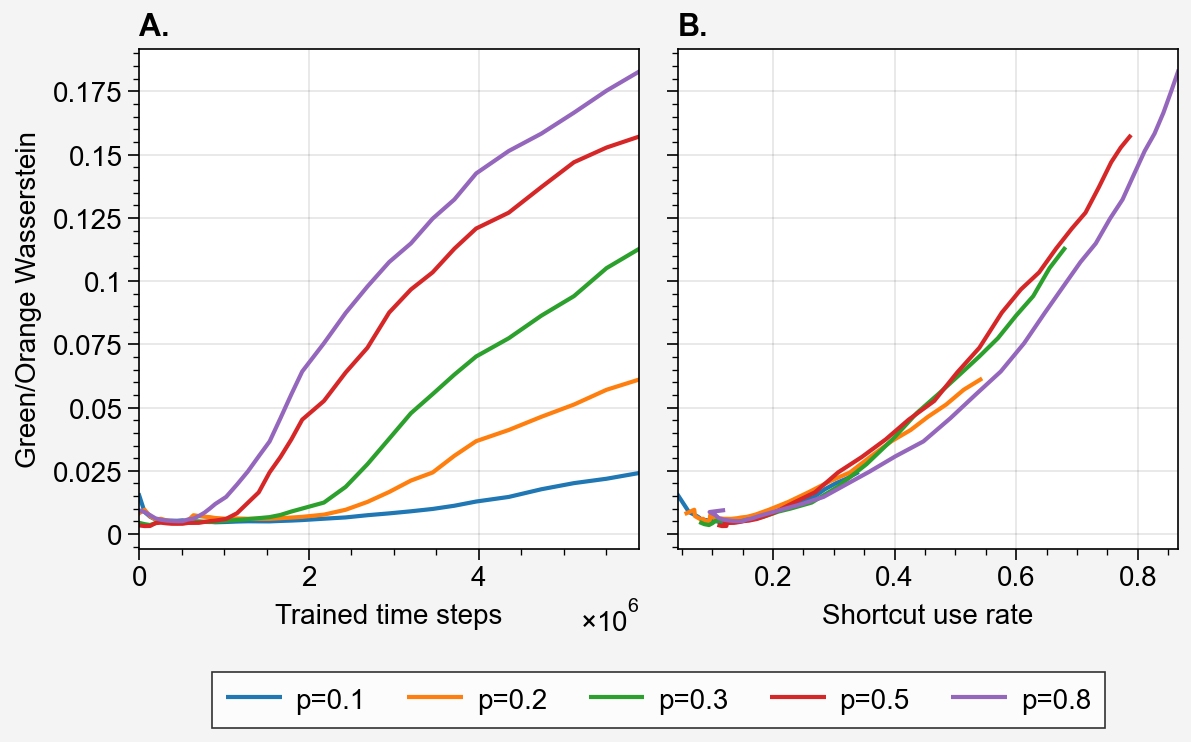

In [87]:
fig, ax = pplt.subplots(ncols=2, sharex=False)
lines = []
# G/O Wasserstein across time steps
for i, p in enumerate(probs):
    res = summary[p]
    
    wassersteins = np.array(res['g_o_wassersteins']).mean(axis=0)
    surs = np.array(res['surs']).mean(axis=0)
    
    surs = pd.Series(surs).ewm(alpha=0.1).mean()
    wassersteins = pd.Series(wassersteins).ewm(alpha=0.1).mean()
    lines.append(ax[0].plot(chk_sched*64*100, wassersteins, label=f'p={p}', color=rgb_colors[i]))


# G/O Wasserstein across performance
for i, p in enumerate(probs):
    res = summary[p]
    
    wassersteins = np.array(res['g_o_wassersteins']).mean(axis=0)
    surs = np.array(res['surs']).mean(axis=0)
    
    surs = pd.Series(surs).ewm(alpha=0.1).mean()
    wassersteins = pd.Series(wassersteins).ewm(alpha=0.1).mean()
    ax[1].plot(surs, wassersteins, label=f'p={p}', color=rgb_colors[i])
    
ax.format(ylabel='Green/Orange Wasserstein', abc='A.')
ax[0].format(xlabel='Trained time steps')
ax[1].format(xlabel='Shortcut use rate')
fig.legend(lines, loc='b', ncols=6)

### Green/orange separation with full 64 dim

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


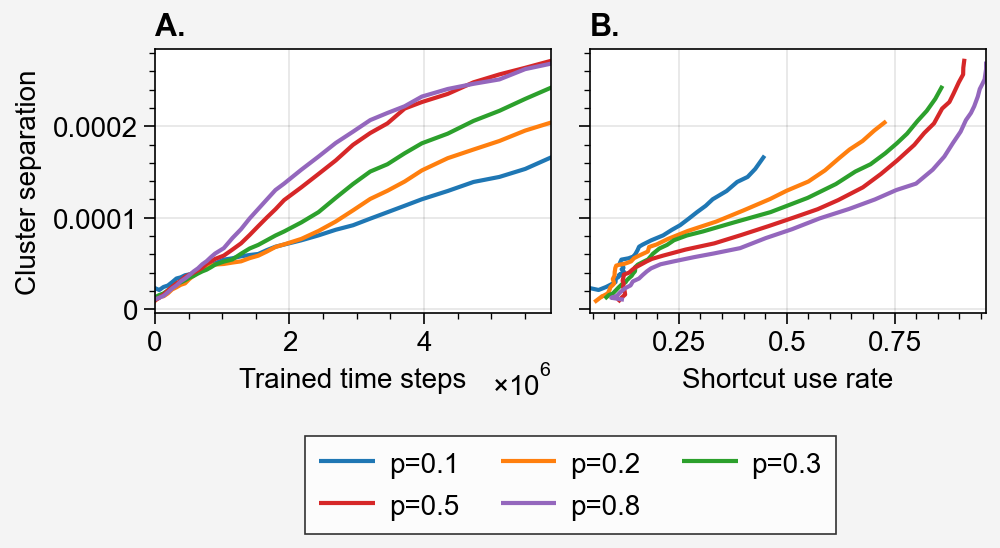

In [28]:
all_g_o = pickle.load(open(folder/'g_o_wasserstein', 'rb'))
open_g_o = pickle.load(open(folder/'g_o_wasserstein_open_only', 'rb'))


fig, ax = pplt.subplots(ncols=2, sharex=False, figwidth=5, refaspect=1.5)
lines = []
# G/O Wasserstein across time steps
for i, p in enumerate(probs):
    res = summary[p]
    
    # wassersteins = np.array(res['g_o_wassersteins']).mean(axis=0)
    wassersteins = np.array(all_g_o['full'][p]).mean(axis=0)
    surs = np.array(res['surs']).mean(axis=0)
    
    surs = pd.Series(surs).ewm(alpha=0.3).mean()
    wassersteins = pd.Series(wassersteins).ewm(alpha=0.3).mean()
    lines.append(ax[0].plot(chk_sched*64*100, wassersteins, label=f'p={p}', color=rgb_colors[i]))


# G/O Wasserstein across performance
for i, p in enumerate(probs):
    res = summary[p]
    
    # wassersteins = np.array(res['g_o_wassersteins']).mean(axis=0)
    wassersteins = np.array(all_g_o['full'][p]).mean(axis=0)
    surs = np.array(res['surs']).mean(axis=0)
    
    surs = pd.Series(surs).ewm(alpha=0.3).mean()
    wassersteins = pd.Series(wassersteins).ewm(alpha=0.3).mean()
    ax[1].plot(surs, wassersteins, label=f'p={p}', color=rgb_colors[i])
    
ax.format(ylabel='Cluster separation', abc='A.')
ax[0].format(xlabel='Trained time steps')
ax[1].format(xlabel='Shortcut use rate')
fig.legend(lines, loc='b', ncols=3)

fig.savefig(save/'4_2_2_traj_cluster_separation_64dim')

### Green/orange separation on open trials only. 64 dim

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


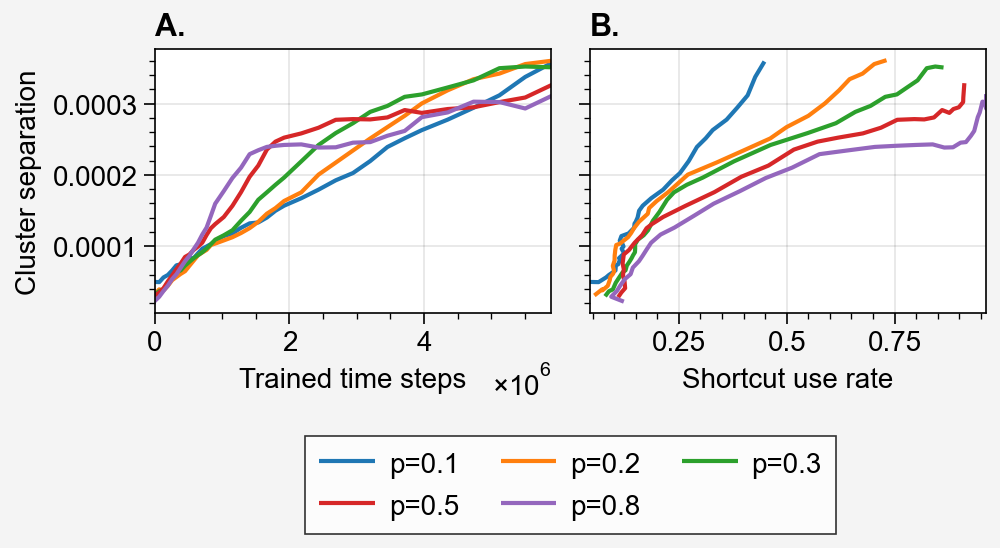

In [30]:
all_g_o = pickle.load(open(folder/'g_o_wasserstein', 'rb'))
open_g_o = pickle.load(open(folder/'g_o_wasserstein_open_only', 'rb'))


fig, ax = pplt.subplots(ncols=2, sharex=False, figwidth=5, refaspect=1.5)
lines = []
# G/O Wasserstein across time steps
for i, p in enumerate(probs):
    res = summary[p]
    
    # wassersteins = np.array(res['g_o_wassersteins']).mean(axis=0)
    wassersteins = np.array(open_g_o['full'][p]).mean(axis=0)
    surs = np.array(res['surs']).mean(axis=0)
    
    surs = pd.Series(surs).ewm(alpha=0.3).mean()
    wassersteins = pd.Series(wassersteins).ewm(alpha=0.3).mean()
    lines.append(ax[0].plot(chk_sched*64*100, wassersteins, label=f'p={p}', color=rgb_colors[i]))


# G/O Wasserstein across performance
for i, p in enumerate(probs):
    res = summary[p]
    
    # wassersteins = np.array(res['g_o_wassersteins']).mean(axis=0)
    wassersteins = np.array(open_g_o['full'][p]).mean(axis=0)
    surs = np.array(res['surs']).mean(axis=0)
    
    surs = pd.Series(surs).ewm(alpha=0.3).mean()
    wassersteins = pd.Series(wassersteins).ewm(alpha=0.3).mean()
    ax[1].plot(surs, wassersteins, label=f'p={p}', color=rgb_colors[i])
    
ax.format(ylabel='Cluster separation', abc='A.')
ax[0].format(xlabel='Trained time steps')
ax[1].format(xlabel='Shortcut use rate')
fig.legend(lines, loc='b', ncols=3)

fig.savefig(save/'4_2_3_traj_cluster_separation_open')

## Green orange separation for shortcut sensitive nodes

Focus on agents with around 0.6 shortcut use rate (but can show for others to), look at G/O wasserstein

In [3]:
folder = Path('data/shortcut/wc1.5_policy')
short_sens_wass = pickle.load(open(folder/'shortcut_sens_wasserstein', 'rb'))

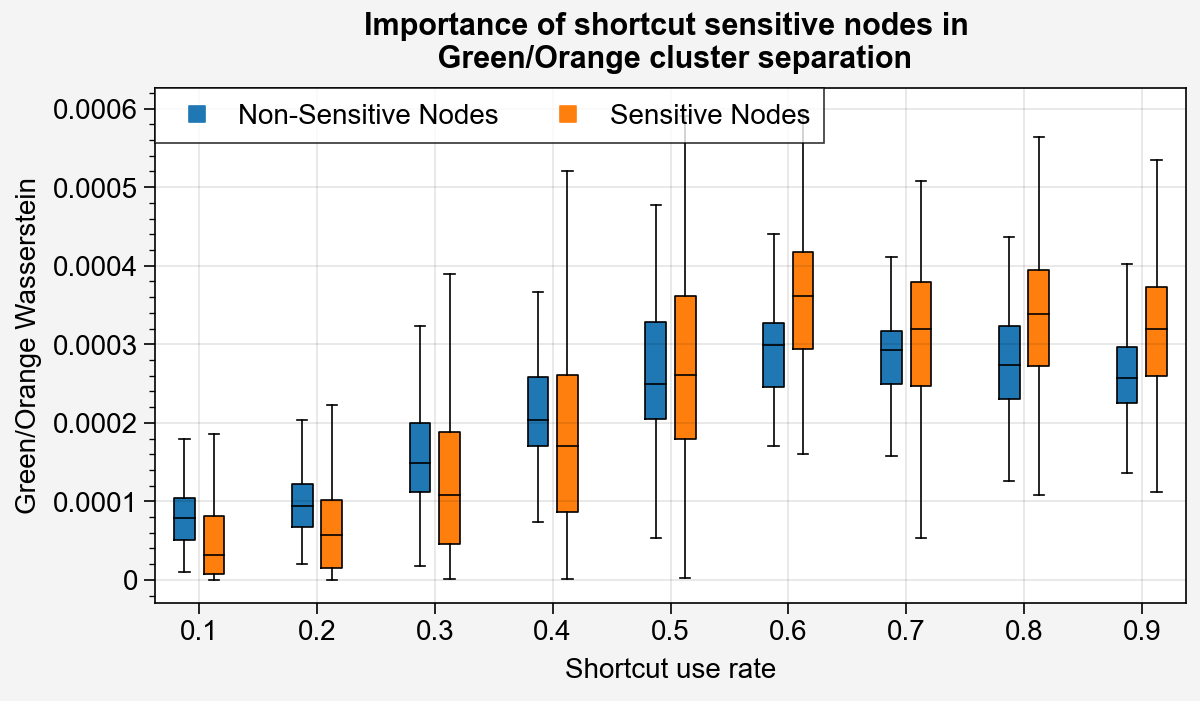

In [105]:
short_sens_wass = pickle.load(open(folder/'open_shortcut_sens_wasserstein', 'rb'))
fig, ax = pplt.subplots(refaspect=2, figwidth=6)

for i, target_sur in enumerate(target_surs):
    sens = np.array([])
    nonsens = np.array([])
    for p in probs:
        surs = np.array(summary[p]['surs'])
        idxs = (surs > (target_sur - 0.05)) & (surs < (target_sur + 0.05))
        sens = np.concatenate([sens, short_sens_wass['sens'][p][idxs]])
        nonsens = np.concatenate([nonsens, short_sens_wass['nonsens'][p][idxs]])

    ax.boxplot([i*4], nonsens, showfliers=False, widths=0.7, fc=rgb_colors[0])
    ax.boxplot([i*4+1], sens, showfliers=False, widths=0.7, fc=rgb_colors[1])

boxes = []
boxes.append(ax.scatter([-5], [0], marker='s', c=rgb_colors[0], label='Non-Sensitive Nodes'))
boxes.append(ax.scatter([-5], [0], marker='s', c=rgb_colors[1], label='Sensitive Nodes'))
ax.legend(boxes)

ax.format(xlocator=np.arange(0.5, 33, 4), xformatter=[f'{s:.1f}' for s in target_surs],
         xlabel='Shortcut use rate', ylabel='Green/Orange Wasserstein',
         xlim=[-1, 34],
         suptitle='Importance of shortcut sensitive nodes in \n Green/Orange cluster separation')

### Prescribed trajectories

In [70]:
copied_wsns = pickle.load(open('data/shortcut/wc1.5_copied/wsns_hms', 'rb'))
policy_wsns = pickle.load(open('data/shortcut/wc1.5_policy/wsns_hms', 'rb'))


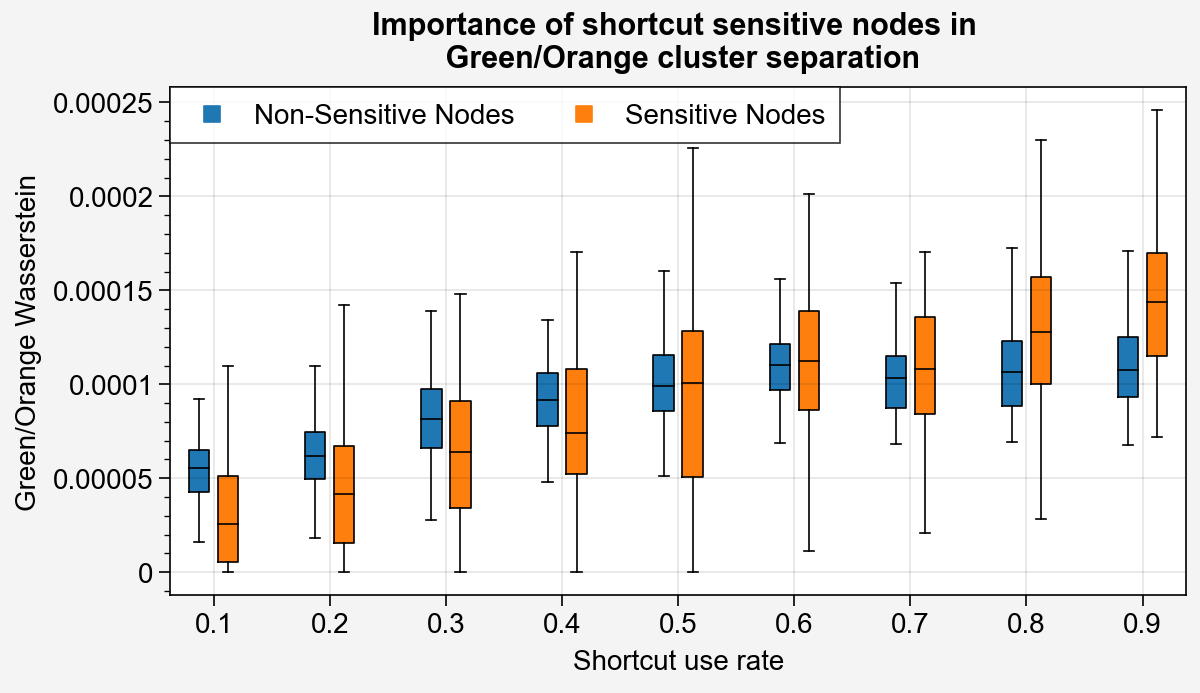

In [104]:

short_sens_wass = pickle.load(open('data/shortcut/wc1.5_copied/shortcut_sens_wasserstein', 'rb'))
# short_sens_wass = pickle.load(open('data/shortcut/wc1.5_copied/shortcut_sens_wasserstein', 'rb'))

fig, ax = pplt.subplots(refaspect=2, figwidth=6)

target_surs = np.arange(0.05, 1, 0.1)
probs = [0.1, 0.2, 0.3, 0.5, 0.8]

nonsens = np.zeros((5, 10, 36))
sens = np.zeros((5, 10, 36))
surs = np.zeros((5, 10, 36))
for i, p in enumerate(probs):
    nonsens[i] = short_sens_wass['nonsens'][p]
    sens[i] = short_sens_wass['sens'][p]
    surs[i] = np.array(summary[p]['surs'])
idxs = ~np.isnan(sens)
sens = sens[idxs]
nonsens = nonsens[idxs]
surs = surs[idxs]

for i, target_sur in enumerate(target_surs):
    idxs = (surs > (target_sur - 0.05)) & (surs < (target_sur + 0.05))

    ax.boxplot([i*4], nonsens[idxs], showfliers=False, widths=0.7, fc=rgb_colors[0])
    ax.boxplot([i*4+1], sens[idxs], showfliers=False, widths=0.7, fc=rgb_colors[1])

boxes = []
boxes.append(ax.scatter([-5], [0], marker='s', c=rgb_colors[0], label='Non-Sensitive Nodes'))
boxes.append(ax.scatter([-5], [0], marker='s', c=rgb_colors[1], label='Sensitive Nodes'))
ax.legend(boxes)

ax.format(xlocator=np.arange(0.5, 33, 4), xformatter=[f'{s:.1f}' for s in target_surs],
         xlabel='Shortcut use rate', ylabel='Green/Orange Wasserstein',
         xlim=[-1, 34],
         suptitle='Importance of shortcut sensitive nodes in \n Green/Orange cluster separation')

<a list of 1 Line2D objects>

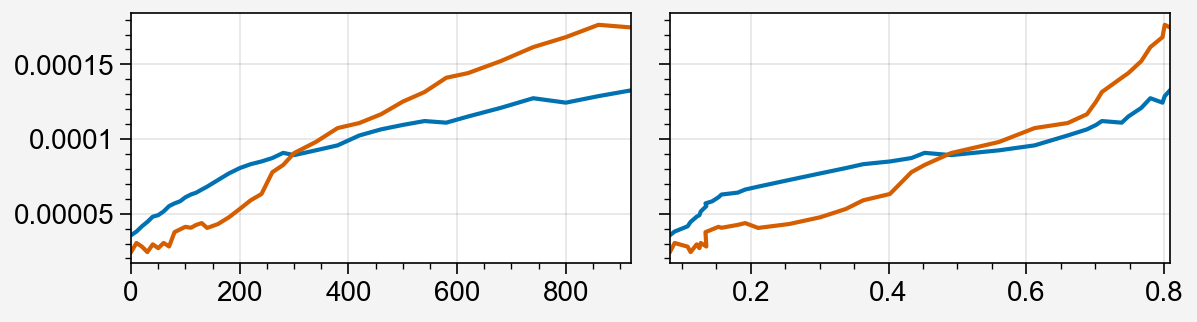

In [49]:
nonsens = np.zeros((5, 10, 36))
sens = np.zeros((5, 10, 36))
surs = np.zeros((5, 10, 36))

#drop nan


for i, p in enumerate(probs):
    nonsens[i] = short_sens_wass['nonsens'][p]
    sens[i] = short_sens_wass['sens'][p]
    surs[i] = np.array(summary[p]['surs'])

fig, ax = pplt.subplots(refaspect=2, ncols=2)
ax[0].plot(chk_sched, np.nanmean(nonsens, axis=0).mean(axis=0))
ax[0].plot(chk_sched, np.nanmean(sens, axis=0).mean(axis=0))

ax[1].plot(surs.mean(axis=0).mean(axis=0), np.nanmean(nonsens, axis=0).mean(axis=0))
ax[1].plot(surs.mean(axis=0).mean(axis=0), np.nanmean(sens, axis=0).mean(axis=0))

## Combined pre-entrance pre-shortcut on prescribed trajectories with role of cue sensitive nodes

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


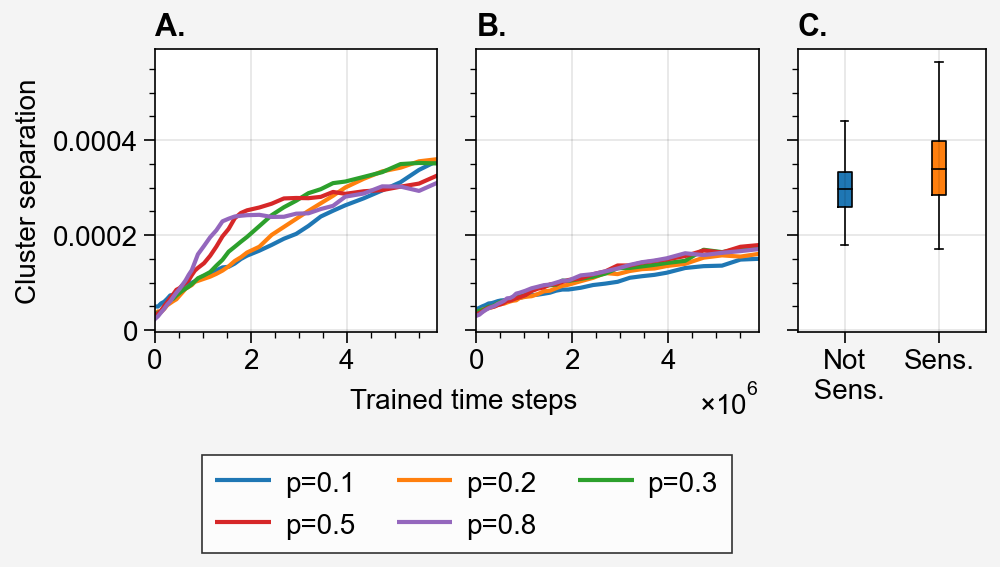

In [109]:
fig, ax = pplt.subplots(ncols=3, width_ratios=[1.5, 1.5, 1], figwidth=5)
folder = Path('data/shortcut/wc1.5_policy')

# Open only, policy trials
open_g_o = pickle.load(open(folder/'g_o_wasserstein_open_only', 'rb'))
lines = []
for i, p in enumerate(probs):
    res = summary[p]    
    wassersteins = np.array(open_g_o['full'][p]).mean(axis=0)
    surs = np.array(res['surs']).mean(axis=0)
    
    surs = pd.Series(surs).ewm(alpha=0.3).mean()
    wassersteins = pd.Series(wassersteins).ewm(alpha=0.3).mean()
    lines.append(ax[0].plot(chk_sched*64*100/1000000, wassersteins, label=f'p={p}', color=rgb_colors[i]))
    
# Prescribed trajectories, closed and open
all_g_o = pickle.load(open('data/shortcut/wc1.5_copied/g_o_wasserstein', 'rb'))
x = chk_sched*64*100
for i, p in enumerate(probs):
    y = np.mean(all_g_o['all'][p], axis=0)
    ax[1].plot(chk_sched*64*100, y, color=rgb_colors[i])


# short_sens_wass = pickle.load(open('data/shortcut/wc1.5_policy/shortcut_sens_wasserstein', 'rb'))
short_sens_wass = pickle.load(open('data/shortcut/wc1.5_policy/open_shortcut_sens_wasserstein', 'rb'))
nonsens = np.zeros((5, 10, 36))
sens = np.zeros((5, 10, 36))
surs = np.zeros((5, 10, 36))
for i, p in enumerate(probs):
    nonsens[i] = short_sens_wass['nonsens'][p]
    sens[i] = short_sens_wass['sens'][p]
    surs[i] = np.array(summary[p]['surs'])
ax[2].boxplot([0], nonsens[:, :, 30:].flatten(), showfliers=False, fc=rgb_colors[0])
ax[2].boxplot([1], sens[:, :, 30:].flatten(), showfliers=False, fc=rgb_colors[1])

ax.format(ylabel='Cluster separation', abc='A.')
ax[2].format(xlocator=[0, 1], xformatter=['Not\n Sens.',  'Sens.'])
fig.legend(lines, loc='b', bbox_to_anchor=(0.35, 1.5, 0.05, 0.8))
fig.text(0.35, 0.28, 'Trained time steps')
# ax.format(ylabel='Cluster separation', ylocator=[0, 0.0002, 0.0004], yformatter=['0', '2', '4'])
# fig.text(0.025, 0.87, r'$\times 10^{-4}$')

fig.savefig(save/'4_4_combined_population_sensitive')